In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from zipfile import ZipFile

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/T1TrainSameSize/'

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=10
    num_workers=0
    model_name='resnext50_32x4d'
    size=200
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=40
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    # batch_size=32
    batch_size = 2
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_cols=['label']
    n_fold=4
    trn_fold=[0, 1, 2]
    train=True
    
if CFG.debug:
    CFG.epochs = 1

In [4]:
# ====================================================
# Library
# ====================================================
import sys
# sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
from io import BytesIO
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    # display(y_true)
    # display(y_pred)
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [7]:
folds = {'filename': [], 'label': []}
for filename in os.listdir(TRAIN_PATH + 'yes/'):
  folds['filename'].append(filename)
  folds['label'].append(1)
for filename in os.listdir(TRAIN_PATH + 'no/'):
  folds['filename'].append(filename)
  folds['label'].append(0)

folds = pd.DataFrame(folds)
Fold = StratifiedKFold(n_splits=CFG.n_fold)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['label'])):
  folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())
display(folds)

fold
0    58
1    57
2    56
3    56
dtype: int64

,filename,label,fold
0,h_Y104.jpg,1,0
1,h_Y105.jpg,1,0
2,h_Y106.jpg,1,0
3,h_Y109.JPG,1,0
4,h_Y11.jpg,1,0
...,...,...,...
222,no.jpg,0,3
223,No13.jpg,0,3
224,No18.jpg,0,3
225,No19.jpg,0,3


In [8]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['filename'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = torch.tensor([self.labels[idx]]).float()
        if(label.item() == 1):
          image = cv2.imread(TRAIN_PATH + 'yes/' + file_name)
          # label = np.array([1]).astype(np.float)
        else:
          image = cv2.imread(TRAIN_PATH + 'no/' + file_name)
          # label = np.array([0]).astype(np.float)
          
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [9]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

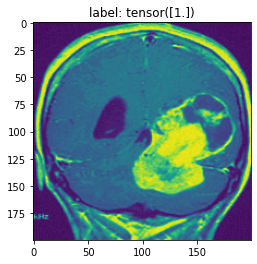

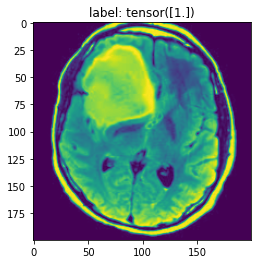

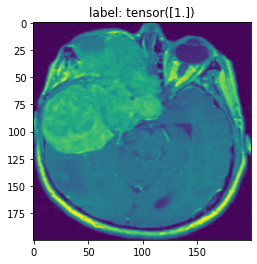

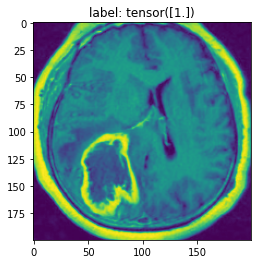

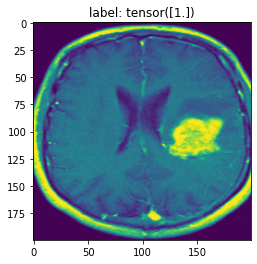

In [10]:
train_dataset = TrainDataset(folds, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [11]:

tst_idx = folds[folds['fold'] == CFG.n_fold - 1].index

test_fold = folds.loc[tst_idx].reset_index(drop=True)
_test_fold = test_fold.copy(deep=True)
test_dataset = TrainDataset(_test_fold, transform=get_transforms(data='valid'))

folds = folds[folds['fold'].isin([i for i in range(CFG.n_fold - 1)])]
display(folds.groupby('fold').size())
display(folds)

fold
0    58
1    57
2    56
dtype: int64

,filename,label,fold
0,h_Y104.jpg,1,0
1,h_Y105.jpg,1,0
2,h_Y106.jpg,1,0
3,h_Y109.JPG,1,0
4,h_Y11.jpg,1,0
...,...,...,...
201,N15.jpg,0,2
202,N16.jpg,0,2
203,N17.jpg,0,2
204,N19.JPG,0,2


In [12]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        if(pretrained):
          self.model.load_state_dict(torch.load('../models/resnext50_32x4d_a1h-0146ab0a.pth'))
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [13]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        # loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [14]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        """
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        """
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    test_loader = DataLoader(test_dataset, 
                        batch_size=CFG.batch_size, 
                        shuffle=False, 
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # test
    test_labels = test_fold[CFG.target_cols].values
    avg_test_loss, preds = valid_fn(test_loader, model, criterion, device)
    score, scores = get_score(test_labels, preds)
    
    LOGGER.info(f"========== fold: {fold} test ==========")
    LOGGER.info(f'test: avg_val_loss: {avg_test_loss:.4f}')
    LOGGER.info(f'test: Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

    return valid_folds

In [15]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold - 1):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                # display(_oof_df)
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [16]:
main()

========== fold: 0 training ==========


Epoch: [1][0/56] Data 0.186 (0.186) Elapsed 0m 2s (remain 2m 0s) Loss: 0.6965(0.6965) Grad: nan  
Epoch: [1][10/56] Data 0.050 (0.051) Elapsed 0m 7s (remain 0m 31s) Loss: 0.6909(0.6926) Grad: 83442.8828  
Epoch: [1][20/56] Data 0.045 (0.048) Elapsed 0m 13s (remain 0m 22s) Loss: 0.6938(0.6876) Grad: 625473.2500  
Epoch: [1][30/56] Data 0.051 (0.045) Elapsed 0m 18s (remain 0m 15s) Loss: 0.5867(0.6897) Grad: 68772.2500  
Epoch: [1][40/56] Data 0.045 (0.045) Elapsed 0m 24s (remain 0m 8s) Loss: 0.5358(0.6712) Grad: 119274.7891  
Epoch: [1][50/56] Data 0.032 (0.044) Elapsed 0m 29s (remain 0m 2s) Loss: 0.7228(0.6654) Grad: 123747.6797  
Epoch: [1][55/56] Data 0.031 (0.044) Elapsed 0m 32s (remain 0m 0s) Loss: 0.6761(0.6675) Grad: 125175.4453  
EVAL: [0/15] Data 0.028 (0.028) Elapsed 0m 0s (remain 0m 1s) Loss: 0.4664(0.4664) 
EVAL: [10/15] Data 0.100 (0.084) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8988(0.5192) 
EVAL: [14/15] Data 0.039 (0.083) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8946(0.6144) 


Epoch 1 - avg_train_loss: 0.6675  avg_val_loss: 0.6144  time: 36s
Epoch 1 - Score: 0.8308  Scores: [0.8308]
Epoch 1 - Save Best Loss: 0.6144 Model


Epoch: [2][0/56] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 31s) Loss: 0.4532(0.4532) Grad: nan  
Epoch: [2][10/56] Data 0.011 (0.013) Elapsed 0m 6s (remain 0m 24s) Loss: 0.4315(0.5596) Grad: 152131.5781  
Epoch: [2][20/56] Data 0.009 (0.015) Elapsed 0m 11s (remain 0m 19s) Loss: 1.0691(0.6176) Grad: 310982.4062  
Epoch: [2][30/56] Data 0.018 (0.044) Elapsed 0m 21s (remain 0m 17s) Loss: 0.3993(0.6158) Grad: 116080.6641  
Epoch: [2][40/56] Data 0.010 (0.066) Elapsed 0m 30s (remain 0m 11s) Loss: 0.4042(0.6383) Grad: 76181.2109  
Epoch: [2][50/56] Data 0.011 (0.056) Elapsed 0m 36s (remain 0m 3s) Loss: 1.0521(0.6655) Grad: 162855.1094  
Epoch: [2][55/56] Data 0.008 (0.052) Elapsed 0m 39s (remain 0m 0s) Loss: 0.3845(0.6448) Grad: 38573.0195  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3954(0.3954) 
EVAL: [10/15] Data 0.023 (0.024) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9095(0.4809) 
EVAL: [14/15] Data 0.010 (0.023) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9081(0.6060) 


Epoch 2 - avg_train_loss: 0.6448  avg_val_loss: 0.6060  time: 43s
Epoch 2 - Score: 0.8359  Scores: [0.8359]
Epoch 2 - Save Best Loss: 0.6060 Model


Epoch: [3][0/56] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 22s) Loss: 1.0979(1.0979) Grad: nan  
Epoch: [3][10/56] Data 0.012 (0.009) Elapsed 0m 6s (remain 0m 26s) Loss: 0.5524(0.6277) Grad: 302188.9688  
Epoch: [3][20/56] Data 0.009 (0.011) Elapsed 0m 12s (remain 0m 20s) Loss: 1.2512(0.6821) Grad: 224324.6719  
Epoch: [3][30/56] Data 0.008 (0.011) Elapsed 0m 18s (remain 0m 14s) Loss: 0.3284(0.6513) Grad: 83334.2891  
Epoch: [3][40/56] Data 0.008 (0.012) Elapsed 0m 25s (remain 0m 9s) Loss: 0.5354(0.6525) Grad: 83325.2656  
Epoch: [3][50/56] Data 0.010 (0.012) Elapsed 0m 32s (remain 0m 3s) Loss: 0.2939(0.6355) Grad: 45461.7148  
Epoch: [3][55/56] Data 0.010 (0.012) Elapsed 0m 36s (remain 0m 0s) Loss: 0.5915(0.6165) Grad: 182404.1250  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2824(0.2824) 
EVAL: [10/15] Data 0.023 (0.023) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9367(0.4229) 
EVAL: [14/15] Data 0.012 (0.024) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9256(0.5763) 


Epoch 3 - avg_train_loss: 0.6165  avg_val_loss: 0.5763  time: 39s
Epoch 3 - Score: 0.9179  Scores: [0.9179]
Epoch 3 - Save Best Loss: 0.5763 Model


Epoch: [4][0/56] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 26s) Loss: 0.2738(0.2738) Grad: inf  
Epoch: [4][10/56] Data 0.012 (0.009) Elapsed 0m 8s (remain 0m 34s) Loss: 0.8670(0.4545) Grad: inf  
Epoch: [4][20/56] Data 0.008 (0.009) Elapsed 0m 15s (remain 0m 26s) Loss: 0.6171(0.4973) Grad: 207438.5781  
Epoch: [4][30/56] Data 0.009 (0.010) Elapsed 0m 22s (remain 0m 18s) Loss: 0.8256(0.4996) Grad: 306453.3438  
Epoch: [4][40/56] Data 0.009 (0.011) Elapsed 0m 30s (remain 0m 10s) Loss: 1.5075(0.5989) Grad: 521856.6875  
Epoch: [4][50/56] Data 0.006 (0.011) Elapsed 0m 36s (remain 0m 3s) Loss: 0.7972(0.5907) Grad: 211074.2344  
Epoch: [4][55/56] Data 0.009 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.4737(0.6044) Grad: 81311.0234  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 6s) Loss: 0.2194(0.2194) 
EVAL: [10/15] Data 0.029 (0.022) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8824(0.3890) 
EVAL: [14/15] Data 0.013 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9121(0.5354) 


Epoch 4 - avg_train_loss: 0.6044  avg_val_loss: 0.5354  time: 44s
Epoch 4 - Score: 0.9293  Scores: [0.9293]
Epoch 4 - Save Best Loss: 0.5354 Model


Epoch: [5][0/56] Data 0.009 (0.009) Elapsed 0m 0s (remain 0m 29s) Loss: 0.2835(0.2835) Grad: nan  
Epoch: [5][10/56] Data 0.008 (0.010) Elapsed 0m 7s (remain 0m 28s) Loss: 0.2133(0.5577) Grad: 150725.3750  
Epoch: [5][20/56] Data 0.008 (0.011) Elapsed 0m 13s (remain 0m 23s) Loss: 0.2210(0.5584) Grad: 84139.4141  
Epoch: [5][30/56] Data 0.008 (0.011) Elapsed 0m 20s (remain 0m 16s) Loss: 0.4363(0.5932) Grad: 48732.7734  
Epoch: [5][40/56] Data 0.007 (0.011) Elapsed 0m 27s (remain 0m 9s) Loss: 1.5577(0.6118) Grad: 619484.5000  
Epoch: [5][50/56] Data 0.013 (0.012) Elapsed 0m 33s (remain 0m 3s) Loss: 0.2220(0.5823) Grad: 29610.8711  
Epoch: [5][55/56] Data 0.009 (0.012) Elapsed 0m 37s (remain 0m 0s) Loss: 0.4599(0.5637) Grad: 95059.0391  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2207(0.2207) 
EVAL: [10/15] Data 0.016 (0.021) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8263(0.3792) 
EVAL: [14/15] Data 0.010 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8420(0.5112) 


Epoch 5 - avg_train_loss: 0.5637  avg_val_loss: 0.5112  time: 41s
Epoch 5 - Score: 0.9634  Scores: [0.9634]
Epoch 5 - Save Best Loss: 0.5112 Model


Epoch: [6][0/56] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 26s) Loss: 1.4358(1.4358) Grad: nan  
Epoch: [6][10/56] Data 0.008 (0.009) Elapsed 0m 8s (remain 0m 34s) Loss: 1.7998(0.6474) Grad: nan  
Epoch: [6][20/56] Data 0.009 (0.009) Elapsed 0m 16s (remain 0m 27s) Loss: 0.5886(0.6306) Grad: 94338.9062  
Epoch: [6][30/56] Data 0.008 (0.010) Elapsed 0m 23s (remain 0m 19s) Loss: 0.6889(0.5678) Grad: 185783.0938  
Epoch: [6][40/56] Data 0.012 (0.011) Elapsed 0m 30s (remain 0m 11s) Loss: 1.2894(0.5461) Grad: 111801.2891  
Epoch: [6][50/56] Data 0.010 (0.011) Elapsed 0m 37s (remain 0m 3s) Loss: 0.2425(0.5122) Grad: 134467.3906  
Epoch: [6][55/56] Data 0.010 (0.012) Elapsed 0m 42s (remain 0m 0s) Loss: 1.3061(0.5180) Grad: 251928.9844  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1732(0.1732) 
EVAL: [10/15] Data 0.015 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7709(0.3261) 
EVAL: [14/15] Data 0.011 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8213(0.4839) 


Epoch 6 - avg_train_loss: 0.5180  avg_val_loss: 0.4839  time: 47s
Epoch 6 - Score: 0.9571  Scores: [0.9571]
Epoch 6 - Save Best Loss: 0.4839 Model


Epoch: [7][0/56] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 24s) Loss: 0.7655(0.7655) Grad: nan  
Epoch: [7][10/56] Data 0.008 (0.009) Elapsed 0m 8s (remain 0m 35s) Loss: 0.4670(0.5558) Grad: 144704.4219  
Epoch: [7][20/56] Data 0.009 (0.012) Elapsed 0m 15s (remain 0m 26s) Loss: 0.4811(0.4560) Grad: 85221.1328  
Epoch: [7][30/56] Data 0.007 (0.012) Elapsed 0m 23s (remain 0m 18s) Loss: 0.1919(0.4549) Grad: 20952.5547  
Epoch: [7][40/56] Data 0.008 (0.012) Elapsed 0m 30s (remain 0m 11s) Loss: 0.2356(0.4857) Grad: 31176.5762  
Epoch: [7][50/56] Data 0.009 (0.012) Elapsed 0m 37s (remain 0m 3s) Loss: 0.9916(0.5294) Grad: 227010.4688  
Epoch: [7][55/56] Data 0.009 (0.012) Elapsed 0m 41s (remain 0m 0s) Loss: 0.3919(0.5254) Grad: 102641.7969  
EVAL: [0/15] Data 0.030 (0.030) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1438(0.1438) 
EVAL: [10/15] Data 0.016 (0.022) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8386(0.3309) 
EVAL: [14/15] Data 0.011 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8307(0.4953) 


Epoch 7 - avg_train_loss: 0.5254  avg_val_loss: 0.4953  time: 45s
Epoch 7 - Score: 0.9533  Scores: [0.9533]


Epoch: [8][0/56] Data 0.008 (0.008) Elapsed 0m 0s (remain 0m 34s) Loss: 0.2118(0.2118) Grad: nan  
Epoch: [8][10/56] Data 0.009 (0.009) Elapsed 0m 7s (remain 0m 31s) Loss: 0.2130(0.3048) Grad: 58162.4648  
Epoch: [8][20/56] Data 0.007 (0.012) Elapsed 0m 14s (remain 0m 24s) Loss: 0.8072(0.4453) Grad: inf  
Epoch: [8][30/56] Data 0.007 (0.011) Elapsed 0m 22s (remain 0m 17s) Loss: 1.9139(0.5016) Grad: 276508.8438  
Epoch: [8][40/56] Data 0.008 (0.011) Elapsed 0m 28s (remain 0m 10s) Loss: 0.6235(0.5390) Grad: 97287.9219  
Epoch: [8][50/56] Data 0.007 (0.011) Elapsed 0m 35s (remain 0m 3s) Loss: 1.3404(0.5442) Grad: 181001.0625  
Epoch: [8][55/56] Data 0.009 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.3880(0.5299) Grad: 32959.0938  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2066(0.2066) 
EVAL: [10/15] Data 0.026 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7713(0.3605) 
EVAL: [14/15] Data 0.011 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7818(0.4854) 


Epoch 8 - avg_train_loss: 0.5299  avg_val_loss: 0.4854  time: 43s
Epoch 8 - Score: 0.9646  Scores: [0.9646]


Epoch: [9][0/56] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 37s) Loss: 0.8402(0.8402) Grad: nan  
Epoch: [9][10/56] Data 0.009 (0.009) Elapsed 0m 7s (remain 0m 32s) Loss: 0.9346(0.4000) Grad: nan  
Epoch: [9][20/56] Data 0.007 (0.009) Elapsed 0m 15s (remain 0m 25s) Loss: 0.4021(0.4455) Grad: 116462.2188  
Epoch: [9][30/56] Data 0.010 (0.010) Elapsed 0m 22s (remain 0m 18s) Loss: 0.2609(0.4790) Grad: 249778.6406  
Epoch: [9][40/56] Data 0.011 (0.011) Elapsed 0m 29s (remain 0m 10s) Loss: 1.4494(0.5544) Grad: 391256.6562  
Epoch: [9][50/56] Data 0.008 (0.011) Elapsed 0m 37s (remain 0m 3s) Loss: 0.1733(0.5382) Grad: 20662.3848  
Epoch: [9][55/56] Data 0.009 (0.012) Elapsed 0m 41s (remain 0m 0s) Loss: 1.7234(0.5461) Grad: 169828.3438  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1159(0.1159) 
EVAL: [10/15] Data 0.022 (0.026) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7570(0.3163) 
EVAL: [14/15] Data 0.011 (0.026) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8344(0.4603) 


Epoch 9 - avg_train_loss: 0.5461  avg_val_loss: 0.4603  time: 45s
Epoch 9 - Score: 0.9684  Scores: [0.9684]
Epoch 9 - Save Best Loss: 0.4603 Model


Epoch: [10][0/56] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 25s) Loss: 0.2620(0.2620) Grad: nan  
Epoch: [10][10/56] Data 0.010 (0.011) Elapsed 0m 7s (remain 0m 30s) Loss: 0.3552(0.6396) Grad: 32278.2090  
Epoch: [10][20/56] Data 0.010 (0.013) Elapsed 0m 13s (remain 0m 23s) Loss: 0.1435(0.6141) Grad: 23318.2988  
Epoch: [10][30/56] Data 0.008 (0.013) Elapsed 0m 21s (remain 0m 17s) Loss: 0.1772(0.5419) Grad: 50215.6836  
Epoch: [10][40/56] Data 0.008 (0.013) Elapsed 0m 29s (remain 0m 10s) Loss: 0.3765(0.5465) Grad: 28861.0625  
Epoch: [10][50/56] Data 0.008 (0.013) Elapsed 0m 37s (remain 0m 3s) Loss: 0.1366(0.5326) Grad: 8057.1099  
Epoch: [10][55/56] Data 0.007 (0.013) Elapsed 0m 41s (remain 0m 0s) Loss: 0.3309(0.5231) Grad: 10510.1045  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1426(0.1426) 
EVAL: [10/15] Data 0.019 (0.023) Elapsed 0m 2s (remain 0m 0s) Loss: 0.6462(0.3169) 
EVAL: [14/15] Data 0.007 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7082(0.4510) 

Epoch 10 - avg_train_loss: 0.5231  avg_val_loss: 0.4510  time: 46s
Epoch 10 - Score: 0.9394  Scores: [0.9394]
Epoch 10 - Save Best Loss: 0.4510 Model


Epoch: [11][0/56] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 26s) Loss: 0.3565(0.3565) Grad: inf  
Epoch: [11][10/56] Data 0.008 (0.010) Elapsed 0m 7s (remain 0m 32s) Loss: 2.0713(0.5556) Grad: nan  
Epoch: [11][20/56] Data 0.010 (0.010) Elapsed 0m 15s (remain 0m 25s) Loss: 0.2906(0.4718) Grad: 16988.4824  
Epoch: [11][30/56] Data 0.008 (0.011) Elapsed 0m 22s (remain 0m 17s) Loss: 0.3207(0.5073) Grad: 47152.0117  
Epoch: [11][40/56] Data 0.008 (0.011) Elapsed 0m 28s (remain 0m 10s) Loss: 0.5195(0.4683) Grad: 26858.9707  
Epoch: [11][50/56] Data 0.008 (0.011) Elapsed 0m 35s (remain 0m 3s) Loss: 0.2650(0.4579) Grad: 74734.8828  
Epoch: [11][55/56] Data 0.014 (0.013) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1965(0.4480) Grad: 29134.8613  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 4s) Loss: 0.1251(0.1251) 
EVAL: [10/15] Data 0.019 (0.022) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3034(0.2584) 
EVAL: [14/15] Data 0.010 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5223(0.3136) 


Epoch 11 - avg_train_loss: 0.4480  avg_val_loss: 0.3136  time: 44s
Epoch 11 - Score: 0.9773  Scores: [0.9773]
Epoch 11 - Save Best Loss: 0.3136 Model


Epoch: [12][0/56] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 25s) Loss: 0.2131(0.2131) Grad: nan  
Epoch: [12][10/56] Data 0.007 (0.009) Elapsed 0m 7s (remain 0m 32s) Loss: 0.1338(0.4202) Grad: 132816.7812  
Epoch: [12][20/56] Data 0.008 (0.013) Elapsed 0m 15s (remain 0m 25s) Loss: 0.2243(0.4990) Grad: 160246.0938  
Epoch: [12][30/56] Data 0.009 (0.013) Elapsed 0m 21s (remain 0m 17s) Loss: 0.1560(0.4552) Grad: 58437.3047  
Epoch: [12][40/56] Data 0.010 (0.013) Elapsed 0m 29s (remain 0m 10s) Loss: 0.0530(0.4794) Grad: 8612.6494  
Epoch: [12][50/56] Data 0.011 (0.013) Elapsed 0m 37s (remain 0m 3s) Loss: 0.0574(0.4704) Grad: 9526.4697  
Epoch: [12][55/56] Data 0.007 (0.013) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0235(0.4466) Grad: 1610.1403  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 2s) Loss: 0.1158(0.1158) 
EVAL: [10/15] Data 0.020 (0.023) Elapsed 0m 2s (remain 0m 1s) Loss: 0.1025(0.2261) 
EVAL: [14/15] Data 0.011 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1223(0.2223) 

Epoch 12 - avg_train_loss: 0.4466  avg_val_loss: 0.2223  time: 44s
Epoch 12 - Score: 0.9785  Scores: [0.9785]
Epoch 12 - Save Best Loss: 0.2223 Model


Epoch: [13][0/56] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 28s) Loss: 0.0195(0.0195) Grad: 45944.3789  
Epoch: [13][10/56] Data 0.009 (0.013) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0230(0.4674) Grad: 7706.4614  
Epoch: [13][20/56] Data 0.007 (0.013) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0138(0.5345) Grad: 1482.7842  
Epoch: [13][30/56] Data 0.009 (0.013) Elapsed 0m 26s (remain 0m 21s) Loss: 0.3034(0.5899) Grad: 242579.8281  
Epoch: [13][40/56] Data 0.006 (0.013) Elapsed 0m 34s (remain 0m 12s) Loss: 0.0094(0.5060) Grad: 462.7009  
Epoch: [13][50/56] Data 0.008 (0.013) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0043(0.4796) Grad: 114.1083  
Epoch: [13][55/56] Data 0.011 (0.013) Elapsed 0m 47s (remain 0m 0s) Loss: 2.2905(0.5426) Grad: 198190.7656  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0479(0.0479) 
EVAL: [10/15] Data 0.016 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0356(0.2153) 
EVAL: [14/15] Data 0.009 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0326(0.22

Epoch 13 - avg_train_loss: 0.5426  avg_val_loss: 0.2223  time: 51s
Epoch 13 - Score: 0.9760  Scores: [0.976]


Epoch: [14][0/56] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 44s) Loss: 0.0180(0.0180) Grad: 332211.0938  
Epoch: [14][10/56] Data 0.006 (0.012) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0394(0.2593) Grad: 32446.8594  
Epoch: [14][20/56] Data 0.008 (0.012) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0280(0.4462) Grad: 44390.8984  
Epoch: [14][30/56] Data 0.007 (0.012) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0612(0.5555) Grad: 39057.1250  
Epoch: [14][40/56] Data 0.008 (0.012) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0042(0.4670) Grad: 265.4930  
Epoch: [14][50/56] Data 0.008 (0.012) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0306(0.4381) Grad: 8553.3203  
Epoch: [14][55/56] Data 0.009 (0.012) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0026(0.4639) Grad: 159.0641  
EVAL: [0/15] Data 0.043 (0.043) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0695(0.0695) 
EVAL: [10/15] Data 0.015 (0.027) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1895(0.1193) 
EVAL: [14/15] Data 0.023 (0.026) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0589(0.24

Epoch 14 - avg_train_loss: 0.4639  avg_val_loss: 0.2447  time: 49s
Epoch 14 - Score: 0.9470  Scores: [0.947]


Epoch: [15][0/56] Data 0.014 (0.014) Elapsed 0m 1s (remain 1m 0s) Loss: 0.0231(0.0231) Grad: 120004.9141  
Epoch: [15][10/56] Data 0.007 (0.017) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0226(0.4561) Grad: 7273.9355  
Epoch: [15][20/56] Data 0.007 (0.015) Elapsed 0m 15s (remain 0m 26s) Loss: 1.7854(0.4294) Grad: inf  
Epoch: [15][30/56] Data 0.007 (0.013) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0103(0.3923) Grad: 7042.4985  
Epoch: [15][40/56] Data 0.010 (0.014) Elapsed 0m 32s (remain 0m 11s) Loss: 0.0033(0.3028) Grad: 745.0535  
Epoch: [15][50/56] Data 0.009 (0.013) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0013(0.3138) Grad: 159.8640  
Epoch: [15][55/56] Data 0.007 (0.014) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0010(0.2914) Grad: 101.1806  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0379(0.0379) 
EVAL: [10/15] Data 0.017 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0745(0.0979) 
EVAL: [14/15] Data 0.014 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0497(0.2457) 


Epoch 15 - avg_train_loss: 0.2914  avg_val_loss: 0.2457  time: 50s
Epoch 15 - Score: 0.9457  Scores: [0.9457]


Epoch: [16][0/56] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 44s) Loss: 0.0017(0.0017) Grad: 9919.2773  
Epoch: [16][10/56] Data 0.009 (0.012) Elapsed 0m 9s (remain 0m 37s) Loss: 1.0495(0.3525) Grad: nan  
Epoch: [16][20/56] Data 0.008 (0.011) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0012(0.3338) Grad: 275.2138  
Epoch: [16][30/56] Data 0.008 (0.011) Elapsed 0m 24s (remain 0m 19s) Loss: 0.5479(0.3328) Grad: inf  
Epoch: [16][40/56] Data 0.009 (0.011) Elapsed 0m 32s (remain 0m 11s) Loss: 0.0011(0.3779) Grad: 68.2217  
Epoch: [16][50/56] Data 0.007 (0.011) Elapsed 0m 40s (remain 0m 3s) Loss: 0.1358(0.4266) Grad: 30085.2910  
Epoch: [16][55/56] Data 0.009 (0.012) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0473(0.3898) Grad: 36119.9844  
EVAL: [0/15] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0350(0.0350) 
EVAL: [10/15] Data 0.025 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0151(0.2154) 
EVAL: [14/15] Data 0.011 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0386(0.2658) 


Epoch 16 - avg_train_loss: 0.3898  avg_val_loss: 0.2658  time: 48s
Epoch 16 - Score: 0.9545  Scores: [0.9545]


Epoch: [17][0/56] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0015(0.0015) Grad: 7090.8618  
Epoch: [17][10/56] Data 0.008 (0.012) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0017(0.0403) Grad: 6890.8223  
Epoch: [17][20/56] Data 0.007 (0.012) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0026(0.2053) Grad: 2933.0920  
Epoch: [17][30/56] Data 0.007 (0.012) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0064(0.2586) Grad: 702.0726  
Epoch: [17][40/56] Data 0.009 (0.012) Elapsed 0m 31s (remain 0m 11s) Loss: 0.0062(0.2666) Grad: 560.9208  
Epoch: [17][50/56] Data 0.007 (0.012) Elapsed 0m 39s (remain 0m 3s) Loss: 0.0026(0.2658) Grad: 347.7168  
Epoch: [17][55/56] Data 0.007 (0.012) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0107(0.2647) Grad: 2310.8149  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0081(0.0081) 
EVAL: [10/15] Data 0.027 (0.023) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2569(0.0847) 
EVAL: [14/15] Data 0.009 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0323(0.2679) 


Epoch 17 - avg_train_loss: 0.2647  avg_val_loss: 0.2679  time: 47s
Epoch 17 - Score: 0.9394  Scores: [0.9394]


Epoch: [18][0/56] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0018(0.0018) Grad: 16173.0078  
Epoch: [18][10/56] Data 0.008 (0.012) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0988(0.0295) Grad: 265565.4375  
Epoch: [18][20/56] Data 0.017 (0.012) Elapsed 0m 16s (remain 0m 26s) Loss: 0.2122(0.1369) Grad: inf  
Epoch: [18][30/56] Data 0.012 (0.011) Elapsed 0m 24s (remain 0m 19s) Loss: 0.0021(0.0946) Grad: 1462.2935  
Epoch: [18][40/56] Data 0.008 (0.011) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0012(0.1045) Grad: 119.0155  
Epoch: [18][50/56] Data 0.007 (0.011) Elapsed 0m 43s (remain 0m 4s) Loss: 0.0049(0.2018) Grad: 307.2934  
Epoch: [18][55/56] Data 0.007 (0.012) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0078(0.2074) Grad: 462.7344  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0326(0.0326) 
EVAL: [10/15] Data 0.014 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0831(0.1974) 
EVAL: [14/15] Data 0.008 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0097(0.2880) 


Epoch 18 - avg_train_loss: 0.2074  avg_val_loss: 0.2880  time: 52s
Epoch 18 - Score: 0.9343  Scores: [0.9343]


Epoch: [19][0/56] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 38s) Loss: 0.0191(0.0191) Grad: inf  
Epoch: [19][10/56] Data 0.007 (0.009) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0019(0.2556) Grad: 2075.5552  
Epoch: [19][20/56] Data 0.008 (0.010) Elapsed 0m 17s (remain 0m 28s) Loss: 0.0011(0.2566) Grad: 667.5939  
Epoch: [19][30/56] Data 0.009 (0.011) Elapsed 0m 26s (remain 0m 21s) Loss: 2.5785(0.3148) Grad: inf  
Epoch: [19][40/56] Data 0.007 (0.010) Elapsed 0m 35s (remain 0m 13s) Loss: 0.0080(0.2411) Grad: 3314.3157  
Epoch: [19][50/56] Data 0.010 (0.011) Elapsed 0m 44s (remain 0m 4s) Loss: 0.0010(0.3339) Grad: 83.4488  
Epoch: [19][55/56] Data 0.009 (0.011) Elapsed 0m 48s (remain 0m 0s) Loss: 0.0061(0.3175) Grad: 1064.5100  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0333(0.0333) 
EVAL: [10/15] Data 0.022 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.2378(0.1218) 
EVAL: [14/15] Data 0.008 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0638(0.2462) 


Epoch 19 - avg_train_loss: 0.3175  avg_val_loss: 0.2462  time: 52s
Epoch 19 - Score: 0.9457  Scores: [0.9457]


Epoch: [20][0/56] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0018(0.0018) Grad: 12101.6260  
Epoch: [20][10/56] Data 0.006 (0.012) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0028(0.0498) Grad: 15118.4199  
Epoch: [20][20/56] Data 0.009 (0.011) Elapsed 0m 17s (remain 0m 28s) Loss: 0.0018(0.2327) Grad: 4355.8770  
Epoch: [20][30/56] Data 0.008 (0.011) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0033(0.2824) Grad: 3385.4402  
Epoch: [20][40/56] Data 0.007 (0.011) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0139(0.2293) Grad: 12946.3477  
Epoch: [20][50/56] Data 0.008 (0.011) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0059(0.1888) Grad: 3384.2351  
Epoch: [20][55/56] Data 0.007 (0.012) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0011(0.2255) Grad: 226.6210  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0185(0.0185) 
EVAL: [10/15] Data 0.016 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1988(0.1677) 
EVAL: [14/15] Data 0.012 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0176(0.259

Epoch 20 - avg_train_loss: 0.2255  avg_val_loss: 0.2590  time: 50s
Epoch 20 - Score: 0.9444  Scores: [0.9444]


Epoch: [21][0/56] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0039(0.0039) Grad: 33374.0703  
Epoch: [21][10/56] Data 0.010 (0.012) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0040(0.5847) Grad: 9262.3096  
Epoch: [21][20/56] Data 0.008 (0.012) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0010(0.4877) Grad: 259.4516  
Epoch: [21][30/56] Data 0.009 (0.012) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0045(0.3362) Grad: 1578.0042  
Epoch: [21][40/56] Data 0.010 (0.012) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0038(0.3296) Grad: 602.2758  
Epoch: [21][50/56] Data 0.014 (0.012) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0048(0.2655) Grad: 1906.4677  
Epoch: [21][55/56] Data 0.008 (0.013) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0150(0.2546) Grad: 3421.6465  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0228(0.0228) 
EVAL: [10/15] Data 0.017 (0.019) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1592(0.1426) 
EVAL: [14/15] Data 0.013 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0156(0.2056) 

Epoch 21 - avg_train_loss: 0.2546  avg_val_loss: 0.2056  time: 50s
Epoch 21 - Score: 0.9646  Scores: [0.9646]
Epoch 21 - Save Best Loss: 0.2056 Model


Epoch: [22][0/56] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 30s) Loss: 0.0007(0.0007) Grad: 5095.6182  
Epoch: [22][10/56] Data 0.011 (0.013) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0007(0.7124) Grad: 170.7765  
Epoch: [22][20/56] Data 0.010 (0.013) Elapsed 0m 15s (remain 0m 25s) Loss: 0.0028(0.4859) Grad: 349.3024  
Epoch: [22][30/56] Data 0.009 (0.013) Elapsed 0m 24s (remain 0m 19s) Loss: 0.5521(0.3974) Grad: 206532.7656  
Epoch: [22][40/56] Data 0.007 (0.012) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0027(0.4250) Grad: 263.7133  
Epoch: [22][50/56] Data 0.011 (0.012) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0045(0.3793) Grad: 2491.3574  
Epoch: [22][55/56] Data 0.008 (0.013) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0030(0.3464) Grad: 572.3954  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0341(0.0341) 
EVAL: [10/15] Data 0.022 (0.022) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0485(0.1241) 
EVAL: [14/15] Data 0.010 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0150(0.2047) 


Epoch 22 - avg_train_loss: 0.3464  avg_val_loss: 0.2047  time: 50s
Epoch 22 - Score: 0.9646  Scores: [0.9646]
Epoch 22 - Save Best Loss: 0.2047 Model


Epoch: [23][0/56] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 25s) Loss: 0.0283(0.0283) Grad: inf  
Epoch: [23][10/56] Data 0.007 (0.011) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0012(0.5008) Grad: 1230.2456  
Epoch: [23][20/56] Data 0.008 (0.011) Elapsed 0m 18s (remain 0m 30s) Loss: 0.0012(0.6778) Grad: 105.9185  
Epoch: [23][30/56] Data 0.009 (0.012) Elapsed 0m 27s (remain 0m 21s) Loss: 2.2171(0.5648) Grad: 191143.4062  
Epoch: [23][40/56] Data 0.007 (0.012) Elapsed 0m 36s (remain 0m 13s) Loss: 0.0004(0.4289) Grad: 20.0738  
Epoch: [23][50/56] Data 0.008 (0.012) Elapsed 0m 45s (remain 0m 4s) Loss: 0.0007(0.4080) Grad: 90.3754  
Epoch: [23][55/56] Data 0.006 (0.013) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0004(0.3720) Grad: 31.1590  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 7s) Loss: 0.0345(0.0345) 
EVAL: [10/15] Data 0.024 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0949(0.2491) 
EVAL: [14/15] Data 0.010 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0426(0.2361) 


Epoch 23 - avg_train_loss: 0.3720  avg_val_loss: 0.2361  time: 54s
Epoch 23 - Score: 0.9722  Scores: [0.9722]


Epoch: [24][0/56] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0327(0.0327) Grad: 116628.2031  
Epoch: [24][10/56] Data 0.007 (0.013) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0019(0.7351) Grad: 3330.7563  
Epoch: [24][20/56] Data 0.009 (0.013) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0282(0.6300) Grad: 10761.2490  
Epoch: [24][30/56] Data 0.007 (0.012) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0022(0.5493) Grad: 893.8402  
Epoch: [24][40/56] Data 0.011 (0.012) Elapsed 0m 35s (remain 0m 13s) Loss: 2.8208(0.5478) Grad: 116976.1562  
Epoch: [24][50/56] Data 0.008 (0.012) Elapsed 0m 44s (remain 0m 4s) Loss: 0.0004(0.4595) Grad: 11.9341  
Epoch: [24][55/56] Data 0.008 (0.013) Elapsed 0m 49s (remain 0m 0s) Loss: 2.2749(0.5131) Grad: 179038.2344  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 1s) Loss: 0.0094(0.0094) 
EVAL: [10/15] Data 0.022 (0.021) Elapsed 0m 4s (remain 0m 1s) Loss: 0.8329(0.2668) 
EVAL: [14/15] Data 0.012 (0.021) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0461(0.2

Epoch 24 - avg_train_loss: 0.5131  avg_val_loss: 0.2680  time: 55s
Epoch 24 - Score: 0.9558  Scores: [0.9558]


Epoch: [25][0/56] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 48s) Loss: 2.5953(2.5953) Grad: nan  
Epoch: [25][10/56] Data 0.008 (0.009) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0023(0.7251) Grad: 4624.4697  
Epoch: [25][20/56] Data 0.007 (0.011) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0009(0.6861) Grad: 153.8358  
Epoch: [25][30/56] Data 0.007 (0.011) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0003(0.5218) Grad: 14.5471  
Epoch: [25][40/56] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 13s) Loss: 0.0004(0.4257) Grad: 35.7237  
Epoch: [25][50/56] Data 0.010 (0.012) Elapsed 0m 45s (remain 0m 4s) Loss: 6.2150(0.4772) Grad: 231133.0625  
Epoch: [25][55/56] Data 0.008 (0.012) Elapsed 0m 50s (remain 0m 0s) Loss: 0.0781(0.5439) Grad: 88536.9844  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0049(0.0049) 
EVAL: [10/15] Data 0.028 (0.022) Elapsed 0m 3s (remain 0m 1s) Loss: 1.1815(0.2191) 
EVAL: [14/15] Data 0.010 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0715(0.2529) 


Epoch 25 - avg_train_loss: 0.5439  avg_val_loss: 0.2529  time: 55s
Epoch 25 - Score: 0.9444  Scores: [0.9444]


Epoch: [26][0/56] Data 0.012 (0.012) Elapsed 0m 1s (remain 0m 56s) Loss: 0.0004(0.0004) Grad: 2017.4220  
Epoch: [26][10/56] Data 0.008 (0.013) Elapsed 0m 9s (remain 0m 40s) Loss: 0.0012(0.3831) Grad: 1601.5925  
Epoch: [26][20/56] Data 0.007 (0.013) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0027(0.2025) Grad: 17872.7051  
Epoch: [26][30/56] Data 0.014 (0.013) Elapsed 0m 27s (remain 0m 22s) Loss: 0.2530(0.2365) Grad: inf  
Epoch: [26][40/56] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 13s) Loss: 0.0338(0.2745) Grad: 16453.4961  
Epoch: [26][50/56] Data 0.006 (0.012) Elapsed 0m 45s (remain 0m 4s) Loss: 0.0002(0.2209) Grad: 79.0763  
Epoch: [26][55/56] Data 0.007 (0.012) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0033(0.2983) Grad: 4073.4160  
EVAL: [0/15] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0350(0.0350) 
EVAL: [10/15] Data 0.023 (0.023) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5150(0.4406) 
EVAL: [14/15] Data 0.012 (0.022) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1399(0.3602) 


Epoch 26 - avg_train_loss: 0.2983  avg_val_loss: 0.3602  time: 55s
Epoch 26 - Score: 0.9545  Scores: [0.9545]


Epoch: [27][0/56] Data 0.029 (0.029) Elapsed 0m 0s (remain 0m 51s) Loss: 0.0007(0.0007) Grad: 8851.5918  
Epoch: [27][10/56] Data 0.009 (0.013) Elapsed 0m 9s (remain 0m 39s) Loss: 3.2235(0.3079) Grad: inf  
Epoch: [27][20/56] Data 0.009 (0.012) Elapsed 0m 18s (remain 0m 30s) Loss: 0.0183(0.1637) Grad: 129174.4688  
Epoch: [27][30/56] Data 0.006 (0.011) Elapsed 0m 27s (remain 0m 21s) Loss: 2.3271(0.1881) Grad: inf  
Epoch: [27][40/56] Data 0.009 (0.011) Elapsed 0m 36s (remain 0m 13s) Loss: 3.3366(0.3016) Grad: 569343.0625  
Epoch: [27][50/56] Data 0.008 (0.011) Elapsed 0m 44s (remain 0m 4s) Loss: 0.0028(0.3698) Grad: 687.0367  
Epoch: [27][55/56] Data 0.011 (0.011) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0003(0.3369) Grad: 30.4683  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0178(0.0178) 
EVAL: [10/15] Data 0.013 (0.022) Elapsed 0m 3s (remain 0m 1s) Loss: 1.0649(0.4482) 
EVAL: [14/15] Data 0.010 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0109(0.3664) 


Epoch 27 - avg_train_loss: 0.3369  avg_val_loss: 0.3664  time: 54s
Epoch 27 - Score: 0.9432  Scores: [0.9432]


Epoch: [28][0/56] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 48s) Loss: 0.0008(0.0008) Grad: 8251.5771  
Epoch: [28][10/56] Data 0.006 (0.013) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0002(0.1910) Grad: 285.7481  
Epoch: [28][20/56] Data 0.008 (0.013) Elapsed 0m 18s (remain 0m 31s) Loss: 0.0003(0.2277) Grad: 399.1434  
Epoch: [28][30/56] Data 0.007 (0.012) Elapsed 0m 27s (remain 0m 22s) Loss: 0.0001(0.1583) Grad: 49.2546  
Epoch: [28][40/56] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 13s) Loss: 0.0008(0.1771) Grad: 475.9207  
Epoch: [28][50/56] Data 0.010 (0.012) Elapsed 0m 45s (remain 0m 4s) Loss: 0.0003(0.2507) Grad: 87.4950  
Epoch: [28][55/56] Data 0.009 (0.012) Elapsed 0m 49s (remain 0m 0s) Loss: 0.0001(0.2283) Grad: 19.9625  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 4s) Loss: 0.0109(0.0109) 
EVAL: [10/15] Data 0.016 (0.018) Elapsed 0m 5s (remain 0m 2s) Loss: 0.9847(0.4244) 
EVAL: [14/15] Data 0.011 (0.017) Elapsed 0m 6s (remain 0m 0s) Loss: 0.0217(0.3529) 


Epoch 28 - avg_train_loss: 0.2283  avg_val_loss: 0.3529  time: 57s
Epoch 28 - Score: 0.9470  Scores: [0.947]


Epoch: [29][0/56] Data 0.008 (0.008) Elapsed 0m 0s (remain 0m 36s) Loss: 0.2834(0.2834) Grad: nan  
Epoch: [29][10/56] Data 0.007 (0.009) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0012(0.0261) Grad: 22052.3457  
Epoch: [29][20/56] Data 0.009 (0.010) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0236(0.5106) Grad: 33738.7461  
Epoch: [29][30/56] Data 0.007 (0.011) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0001(0.3470) Grad: 75.8796  
Epoch: [29][40/56] Data 0.009 (0.012) Elapsed 0m 34s (remain 0m 12s) Loss: 0.0006(0.3456) Grad: 630.0668  
Epoch: [29][50/56] Data 0.008 (0.012) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0146(0.2786) Grad: 2876.7939  
Epoch: [29][55/56] Data 0.007 (0.013) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0015(0.3100) Grad: 1135.8759  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0072(0.0072) 
EVAL: [10/15] Data 0.027 (0.024) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7439(0.3884) 
EVAL: [14/15] Data 0.013 (0.023) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0063(0.3251) 


Epoch 29 - avg_train_loss: 0.3100  avg_val_loss: 0.3251  time: 51s
Epoch 29 - Score: 0.9609  Scores: [0.9609]


Epoch: [30][0/56] Data 0.064 (0.064) Elapsed 0m 0s (remain 0m 42s) Loss: 3.4615(3.4615) Grad: inf  
Epoch: [30][10/56] Data 0.007 (0.014) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0004(0.3232) Grad: 402.3171  
Epoch: [30][20/56] Data 0.008 (0.014) Elapsed 0m 17s (remain 0m 28s) Loss: 0.0004(0.1700) Grad: 368.5306  
Epoch: [30][30/56] Data 0.010 (0.014) Elapsed 0m 25s (remain 0m 20s) Loss: 0.0003(0.1165) Grad: 691.6570  
Epoch: [30][40/56] Data 0.049 (0.015) Elapsed 0m 34s (remain 0m 12s) Loss: 0.0005(0.0894) Grad: 2338.7290  
Epoch: [30][50/56] Data 0.012 (0.015) Elapsed 0m 42s (remain 0m 4s) Loss: 0.0018(0.0723) Grad: 11538.7168  
Epoch: [30][55/56] Data 0.014 (0.016) Elapsed 0m 46s (remain 0m 0s) Loss: 4.8050(0.1517) Grad: inf  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0105(0.0105) 
EVAL: [10/15] Data 0.017 (0.024) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9169(0.3655) 
EVAL: [14/15] Data 0.014 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0364(0.3183) 


Epoch 30 - avg_train_loss: 0.1517  avg_val_loss: 0.3183  time: 50s
Epoch 30 - Score: 0.9533  Scores: [0.9533]


Epoch: [31][0/56] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0002(0.0002) Grad: 1038.1525  
Epoch: [31][10/56] Data 0.008 (0.012) Elapsed 0m 7s (remain 0m 30s) Loss: 2.7876(0.2571) Grad: nan  
Epoch: [31][20/56] Data 0.008 (0.011) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0002(0.1362) Grad: 389.5333  
Epoch: [31][30/56] Data 0.009 (0.012) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0005(0.1766) Grad: 282.0819  
Epoch: [31][40/56] Data 0.006 (0.012) Elapsed 0m 28s (remain 0m 10s) Loss: 0.0002(0.1400) Grad: 27.4062  
Epoch: [31][50/56] Data 0.007 (0.012) Elapsed 0m 35s (remain 0m 3s) Loss: 0.0003(0.1259) Grad: 38.2474  
Epoch: [31][55/56] Data 0.006 (0.013) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0001(0.1150) Grad: 7.8452  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0174(0.0174) 
EVAL: [10/15] Data 0.025 (0.023) Elapsed 0m 3s (remain 0m 1s) Loss: 1.0144(0.4389) 
EVAL: [14/15] Data 0.007 (0.022) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0575(0.3628) 


Epoch 31 - avg_train_loss: 0.1150  avg_val_loss: 0.3628  time: 44s
Epoch 31 - Score: 0.9457  Scores: [0.9457]


Epoch: [32][0/56] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 49s) Loss: 0.0006(0.0006) Grad: 4006.7673  
Epoch: [32][10/56] Data 0.007 (0.014) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0005(0.1127) Grad: 1828.2269  
Epoch: [32][20/56] Data 0.011 (0.013) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0003(0.1949) Grad: 1140.3389  
Epoch: [32][30/56] Data 0.009 (0.013) Elapsed 0m 24s (remain 0m 19s) Loss: 0.0001(0.1331) Grad: 211.2403  
Epoch: [32][40/56] Data 0.007 (0.013) Elapsed 0m 32s (remain 0m 11s) Loss: 0.0003(0.2189) Grad: 321.0176  
Epoch: [32][50/56] Data 0.008 (0.013) Elapsed 0m 39s (remain 0m 3s) Loss: 0.0015(0.1970) Grad: 2283.5872  
Epoch: [32][55/56] Data 0.007 (0.013) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0017(0.2511) Grad: 1621.7234  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0067(0.0067) 
EVAL: [10/15] Data 0.023 (0.022) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9846(0.3169) 
EVAL: [14/15] Data 0.011 (0.022) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0663(0.3038) 


Epoch 32 - avg_train_loss: 0.2511  avg_val_loss: 0.3038  time: 48s
Epoch 32 - Score: 0.9495  Scores: [0.9495]


Epoch: [33][0/56] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 38s) Loss: 0.0185(0.0185) Grad: inf  
Epoch: [33][10/56] Data 0.010 (0.009) Elapsed 0m 8s (remain 0m 34s) Loss: 3.2391(0.2990) Grad: nan  
Epoch: [33][20/56] Data 0.010 (0.009) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0001(0.1588) Grad: 92.8645  
Epoch: [33][30/56] Data 0.010 (0.010) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0119(0.2208) Grad: 3944.7725  
Epoch: [33][40/56] Data 0.008 (0.011) Elapsed 0m 31s (remain 0m 11s) Loss: 0.0007(0.1697) Grad: 1367.0203  
Epoch: [33][50/56] Data 0.008 (0.011) Elapsed 0m 38s (remain 0m 3s) Loss: 0.0019(0.1911) Grad: 5140.1963  
Epoch: [33][55/56] Data 0.010 (0.012) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0001(0.1741) Grad: 50.6256  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0095(0.0095) 
EVAL: [10/15] Data 0.027 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9556(0.2914) 
EVAL: [14/15] Data 0.008 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0345(0.2555) 


Epoch 33 - avg_train_loss: 0.1741  avg_val_loss: 0.2555  time: 47s
Epoch 33 - Score: 0.9596  Scores: [0.9596]


Epoch: [34][0/56] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 39s) Loss: 4.6447(4.6447) Grad: nan  
Epoch: [34][10/56] Data 0.007 (0.010) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0267(0.9157) Grad: 89879.9453  
Epoch: [34][20/56] Data 0.008 (0.011) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0005(0.5171) Grad: 232.6053  
Epoch: [34][30/56] Data 0.007 (0.012) Elapsed 0m 23s (remain 0m 18s) Loss: 0.0001(0.3940) Grad: 6.3684  
Epoch: [34][40/56] Data 0.007 (0.012) Elapsed 0m 31s (remain 0m 11s) Loss: 0.0002(0.3429) Grad: 20.5625  
Epoch: [34][50/56] Data 0.007 (0.012) Elapsed 0m 38s (remain 0m 3s) Loss: 0.0001(0.2791) Grad: 5.9527  
Epoch: [34][55/56] Data 0.011 (0.012) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0004(0.2542) Grad: 32.4022  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0047(0.0047) 
EVAL: [10/15] Data 0.023 (0.019) Elapsed 0m 3s (remain 0m 1s) Loss: 1.0868(0.4102) 
EVAL: [14/15] Data 0.009 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0092(0.3667) 


Epoch 34 - avg_train_loss: 0.2542  avg_val_loss: 0.3667  time: 47s
Epoch 34 - Score: 0.9407  Scores: [0.9407]


Epoch: [35][0/56] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0004(0.0004) Grad: 2693.5696  
Epoch: [35][10/56] Data 0.008 (0.013) Elapsed 0m 8s (remain 0m 34s) Loss: 0.2056(0.0269) Grad: nan  
Epoch: [35][20/56] Data 0.009 (0.011) Elapsed 0m 16s (remain 0m 26s) Loss: 0.0001(0.1465) Grad: 37.7724  
Epoch: [35][30/56] Data 0.007 (0.012) Elapsed 0m 24s (remain 0m 19s) Loss: 0.0105(0.0997) Grad: 6865.5000  
Epoch: [35][40/56] Data 0.009 (0.012) Elapsed 0m 32s (remain 0m 11s) Loss: 0.0005(0.2675) Grad: 189.4482  
Epoch: [35][50/56] Data 0.008 (0.012) Elapsed 0m 40s (remain 0m 3s) Loss: 0.0001(0.2169) Grad: 11.6815  
Epoch: [35][55/56] Data 0.008 (0.012) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0000(0.1975) Grad: 4.7780  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0076(0.0076) 
EVAL: [10/15] Data 0.018 (0.022) Elapsed 0m 3s (remain 0m 1s) Loss: 1.3504(0.4617) 
EVAL: [14/15] Data 0.011 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0203(0.4081) 


Epoch 35 - avg_train_loss: 0.1975  avg_val_loss: 0.4081  time: 48s
Epoch 35 - Score: 0.9255  Scores: [0.9255]


Epoch: [36][0/56] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0001(0.0001) Grad: 666.3994  
Epoch: [36][10/56] Data 0.013 (0.013) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0000(0.2560) Grad: 104.4201  
Epoch: [36][20/56] Data 0.007 (0.013) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0001(0.1344) Grad: 191.2810  
Epoch: [36][30/56] Data 0.008 (0.012) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0001(0.0911) Grad: 595.8412  
Epoch: [36][40/56] Data 0.006 (0.012) Elapsed 0m 31s (remain 0m 11s) Loss: 0.0001(0.0689) Grad: 325.3065  
Epoch: [36][50/56] Data 0.007 (0.012) Elapsed 0m 39s (remain 0m 3s) Loss: 0.0000(0.0695) Grad: 18.5454  
Epoch: [36][55/56] Data 0.008 (0.013) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0002(0.0649) Grad: 399.3860  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0046(0.0046) 
EVAL: [10/15] Data 0.017 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 1.3395(0.3905) 
EVAL: [14/15] Data 0.016 (0.032) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0093(0.3546) 


Epoch 36 - avg_train_loss: 0.0649  avg_val_loss: 0.3546  time: 48s
Epoch 36 - Score: 0.9331  Scores: [0.9331]


Epoch: [37][0/56] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0002(0.0002) Grad: 1058.1672  
Epoch: [37][10/56] Data 0.010 (0.012) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0084(0.0078) Grad: 39021.8711  
Epoch: [37][20/56] Data 0.007 (0.011) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0001(0.0054) Grad: 141.1620  
Epoch: [37][30/56] Data 0.009 (0.012) Elapsed 0m 24s (remain 0m 19s) Loss: 0.0000(0.0044) Grad: 67.8034  
Epoch: [37][40/56] Data 0.007 (0.012) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0000(0.0037) Grad: 57.2111  
Epoch: [37][50/56] Data 0.008 (0.012) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0002(0.1412) Grad: 758.7223  
Epoch: [37][55/56] Data 0.010 (0.012) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0001(0.1288) Grad: 109.3863  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0027(0.0027) 
EVAL: [10/15] Data 0.017 (0.021) Elapsed 0m 2s (remain 0m 1s) Loss: 1.2703(0.4288) 
EVAL: [14/15] Data 0.012 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0067(0.3873) 


Epoch 37 - avg_train_loss: 0.1288  avg_val_loss: 0.3873  time: 49s
Epoch 37 - Score: 0.9331  Scores: [0.9331]


Epoch: [38][0/56] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0087(0.0087) Grad: 70276.8594  
Epoch: [38][10/56] Data 0.007 (0.012) Elapsed 0m 9s (remain 0m 37s) Loss: 0.0001(0.7611) Grad: 64.2104  
Epoch: [38][20/56] Data 0.008 (0.012) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0002(0.4049) Grad: 350.1829  
Epoch: [38][30/56] Data 0.011 (0.012) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0001(0.4123) Grad: 206.9228  
Epoch: [38][40/56] Data 0.007 (0.012) Elapsed 0m 33s (remain 0m 12s) Loss: 0.0001(0.4273) Grad: 77.7855  
Epoch: [38][50/56] Data 0.008 (0.013) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0068(0.3447) Grad: 973.6443  
Epoch: [38][55/56] Data 0.008 (0.013) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0001(0.3172) Grad: 9.4638  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0025(0.0025) 
EVAL: [10/15] Data 0.031 (0.025) Elapsed 0m 2s (remain 0m 1s) Loss: 1.4210(0.3468) 
EVAL: [14/15] Data 0.009 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0247(0.3551) 


Epoch 38 - avg_train_loss: 0.3172  avg_val_loss: 0.3551  time: 48s
Epoch 38 - Score: 0.9369  Scores: [0.9369]


Epoch: [39][0/56] Data 0.058 (0.058) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0000(0.0000) Grad: 191.0714  
Epoch: [39][10/56] Data 0.009 (0.018) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0003(0.0001) Grad: 2089.3450  
Epoch: [39][20/56] Data 0.011 (0.016) Elapsed 0m 18s (remain 0m 30s) Loss: 0.0058(0.0030) Grad: 122130.1406  
Epoch: [39][30/56] Data 0.008 (0.015) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0002(0.0020) Grad: 951.3006  
Epoch: [39][40/56] Data 0.008 (0.014) Elapsed 0m 35s (remain 0m 12s) Loss: 0.0002(0.0041) Grad: 582.2752  
Epoch: [39][50/56] Data 0.007 (0.013) Elapsed 0m 43s (remain 0m 4s) Loss: 0.2176(0.1827) Grad: inf  
Epoch: [39][55/56] Data 0.006 (0.013) Elapsed 0m 47s (remain 0m 0s) Loss: 0.0001(0.1673) Grad: 54.3936  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1213(0.1213) 
EVAL: [10/15] Data 0.015 (0.023) Elapsed 0m 3s (remain 0m 1s) Loss: 1.5541(0.3636) 
EVAL: [14/15] Data 0.007 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0112(0.3799) 


Epoch 39 - avg_train_loss: 0.1673  avg_val_loss: 0.3799  time: 52s
Epoch 39 - Score: 0.9167  Scores: [0.9167]


Epoch: [40][0/56] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 52s) Loss: 0.0001(0.0001) Grad: 3918.5530  
Epoch: [40][10/56] Data 0.008 (0.012) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0002(0.0020) Grad: 2171.7686  
Epoch: [40][20/56] Data 0.011 (0.012) Elapsed 0m 18s (remain 0m 30s) Loss: 0.0002(0.0013) Grad: 4701.6172  
Epoch: [40][30/56] Data 0.008 (0.012) Elapsed 0m 26s (remain 0m 21s) Loss: 0.0001(0.0014) Grad: 828.6796  
Epoch: [40][40/56] Data 0.010 (0.012) Elapsed 0m 34s (remain 0m 12s) Loss: 0.0000(0.0015) Grad: 209.2759  
Epoch: [40][50/56] Data 0.011 (0.012) Elapsed 0m 42s (remain 0m 4s) Loss: 3.2157(0.0644) Grad: nan  
Epoch: [40][55/56] Data 0.007 (0.012) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0000(0.0608) Grad: 51.0751  
EVAL: [0/15] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 7s) Loss: 0.0033(0.0033) 
EVAL: [10/15] Data 0.026 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 1.2934(0.4018) 
EVAL: [14/15] Data 0.010 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0141(0.3629) 


Epoch 40 - avg_train_loss: 0.0608  avg_val_loss: 0.3629  time: 51s
Epoch 40 - Score: 0.9407  Scores: [0.9407]


EVAL: [0/28] Data 0.026 (0.026) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0309(0.0309) 
EVAL: [10/28] Data 0.030 (0.031) Elapsed 0m 1s (remain 0m 2s) Loss: 0.0493(1.1709) 
EVAL: [20/28] Data 0.032 (0.036) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0198(0.6702) 
EVAL: [27/28] Data 0.030 (0.036) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0001(0.5132) 


========== fold: 0 test ==========
test: avg_val_loss: 0.5132
test: Score: 0.9796  Scores: [0.9796]
========== fold: 0 result ==========
Score: 0.9646  Scores: [0.9646]
========== fold: 1 training ==========


Epoch: [1][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 32s) Loss: 0.6914(0.6914) Grad: nan  
Epoch: [1][10/57] Data 0.008 (0.009) Elapsed 0m 9s (remain 0m 41s) Loss: 0.7630(0.6912) Grad: 66563.1328  
Epoch: [1][20/57] Data 0.008 (0.010) Elapsed 0m 18s (remain 0m 32s) Loss: 0.6088(0.6757) Grad: 43603.8125  
Epoch: [1][30/57] Data 0.007 (0.011) Elapsed 0m 27s (remain 0m 22s) Loss: 0.9054(0.6609) Grad: 45894.1992  
Epoch: [1][40/57] Data 0.009 (0.011) Elapsed 0m 35s (remain 0m 13s) Loss: 0.9975(0.6660) Grad: 40512.5039  
Epoch: [1][50/57] Data 0.008 (0.011) Elapsed 0m 44s (remain 0m 5s) Loss: 0.4735(0.6654) Grad: 14378.0039  
Epoch: [1][56/57] Data 0.007 (0.012) Elapsed 0m 49s (remain 0m 0s) Loss: 0.4737(0.6721) Grad: 15524.0020  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.4829(0.4829) 
EVAL: [10/15] Data 0.021 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8350(0.5558) 
EVAL: [14/15] Data 0.005 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8712(0.6308) 


Epoch 1 - avg_train_loss: 0.6721  avg_val_loss: 0.6308  time: 53s
Epoch 1 - Score: 0.8714  Scores: [0.8714]
Epoch 1 - Save Best Loss: 0.6308 Model


Epoch: [2][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 26s) Loss: 0.4491(0.4491) Grad: inf  
Epoch: [2][10/57] Data 0.010 (0.010) Elapsed 0m 9s (remain 0m 40s) Loss: 0.7343(0.6061) Grad: 317665.9062  
Epoch: [2][20/57] Data 0.009 (0.011) Elapsed 0m 18s (remain 0m 31s) Loss: 0.4307(0.6110) Grad: 61294.5508  
Epoch: [2][30/57] Data 0.007 (0.011) Elapsed 0m 27s (remain 0m 23s) Loss: 0.7887(0.5900) Grad: 287814.4688  
Epoch: [2][40/57] Data 0.007 (0.011) Elapsed 0m 36s (remain 0m 14s) Loss: 0.5870(0.6322) Grad: 129299.0312  
Epoch: [2][50/57] Data 0.009 (0.012) Elapsed 0m 43s (remain 0m 5s) Loss: 0.4062(0.6313) Grad: 81028.3906  
Epoch: [2][56/57] Data 0.009 (0.012) Elapsed 0m 47s (remain 0m 0s) Loss: 0.6109(0.6320) Grad: 169982.0625  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 5s) Loss: 0.4423(0.4423) 
EVAL: [10/15] Data 0.022 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8467(0.4914) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9255(0.5961) 


Epoch 2 - avg_train_loss: 0.6320  avg_val_loss: 0.5961  time: 52s
Epoch 2 - Score: 0.8909  Scores: [0.8909]
Epoch 2 - Save Best Loss: 0.5961 Model


Epoch: [3][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 26s) Loss: 0.3854(0.3854) Grad: inf  
Epoch: [3][10/57] Data 0.007 (0.010) Elapsed 0m 7s (remain 0m 31s) Loss: 0.6883(0.5361) Grad: 388552.3125  
Epoch: [3][20/57] Data 0.008 (0.011) Elapsed 0m 15s (remain 0m 26s) Loss: 0.5548(0.6084) Grad: 211982.6875  
Epoch: [3][30/57] Data 0.008 (0.011) Elapsed 0m 23s (remain 0m 19s) Loss: 1.1458(0.6061) Grad: 206794.4062  
Epoch: [3][40/57] Data 0.011 (0.011) Elapsed 0m 31s (remain 0m 12s) Loss: 0.6306(0.6277) Grad: 123780.8828  
Epoch: [3][50/57] Data 0.008 (0.012) Elapsed 0m 39s (remain 0m 4s) Loss: 0.7504(0.6279) Grad: 244659.5312  
Epoch: [3][56/57] Data 0.008 (0.012) Elapsed 0m 43s (remain 0m 0s) Loss: 0.3744(0.6059) Grad: 97872.4688  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.4226(0.4226) 
EVAL: [10/15] Data 0.032 (0.022) Elapsed 0m 2s (remain 0m 1s) Loss: 0.9119(0.4638) 
EVAL: [14/15] Data 0.004 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8972(0.5814) 


Epoch 3 - avg_train_loss: 0.6059  avg_val_loss: 0.5814  time: 48s
Epoch 3 - Score: 0.9195  Scores: [0.9195]
Epoch 3 - Save Best Loss: 0.5814 Model


Epoch: [4][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 27s) Loss: 0.3748(0.3748) Grad: inf  
Epoch: [4][10/57] Data 0.008 (0.010) Elapsed 0m 8s (remain 0m 33s) Loss: 0.5476(0.4130) Grad: 282909.0312  
Epoch: [4][20/57] Data 0.007 (0.011) Elapsed 0m 16s (remain 0m 28s) Loss: 0.4836(0.5141) Grad: 68188.6875  
Epoch: [4][30/57] Data 0.008 (0.011) Elapsed 0m 26s (remain 0m 21s) Loss: 0.5463(0.5613) Grad: 105658.4375  
Epoch: [4][40/57] Data 0.007 (0.012) Elapsed 0m 34s (remain 0m 13s) Loss: 1.3643(0.6053) Grad: 211316.2500  
Epoch: [4][50/57] Data 0.007 (0.012) Elapsed 0m 42s (remain 0m 4s) Loss: 0.3403(0.6193) Grad: 83363.2969  
Epoch: [4][56/57] Data 0.008 (0.012) Elapsed 0m 46s (remain 0m 0s) Loss: 0.4595(0.6026) Grad: 54548.1523  
EVAL: [0/15] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 8s) Loss: 0.3922(0.3922) 
EVAL: [10/15] Data 0.017 (0.019) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9113(0.4548) 
EVAL: [14/15] Data 0.006 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9348(0.5715) 


Epoch 4 - avg_train_loss: 0.6026  avg_val_loss: 0.5715  time: 51s
Epoch 4 - Score: 0.9052  Scores: [0.9052]
Epoch 4 - Save Best Loss: 0.5715 Model


Epoch: [5][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 25s) Loss: 0.3259(0.3259) Grad: inf  
Epoch: [5][10/57] Data 0.008 (0.009) Elapsed 0m 8s (remain 0m 36s) Loss: 0.3324(0.5915) Grad: 57802.3164  
Epoch: [5][20/57] Data 0.007 (0.011) Elapsed 0m 16s (remain 0m 27s) Loss: 0.3298(0.5640) Grad: 65113.1836  
Epoch: [5][30/57] Data 0.007 (0.011) Elapsed 0m 24s (remain 0m 20s) Loss: 0.3178(0.5283) Grad: 60464.5273  
Epoch: [5][40/57] Data 0.007 (0.012) Elapsed 0m 31s (remain 0m 12s) Loss: 1.2407(0.5601) Grad: 484814.6562  
Epoch: [5][50/57] Data 0.008 (0.012) Elapsed 0m 39s (remain 0m 4s) Loss: 0.9268(0.5904) Grad: 387174.6562  
Epoch: [5][56/57] Data 0.006 (0.012) Elapsed 0m 44s (remain 0m 0s) Loss: 0.5117(0.5950) Grad: 85044.5391  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3906(0.3906) 
EVAL: [10/15] Data 0.016 (0.028) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8910(0.4514) 
EVAL: [14/15] Data 0.003 (0.025) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9320(0.5740) 


Epoch 5 - avg_train_loss: 0.5950  avg_val_loss: 0.5740  time: 47s
Epoch 5 - Score: 0.9039  Scores: [0.9039]


Epoch: [6][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 27s) Loss: 0.2715(0.2715) Grad: inf  
Epoch: [6][10/57] Data 0.008 (0.009) Elapsed 0m 8s (remain 0m 33s) Loss: 0.2807(0.5246) Grad: 97560.6016  
Epoch: [6][20/57] Data 0.008 (0.010) Elapsed 0m 15s (remain 0m 26s) Loss: 0.2850(0.5541) Grad: 125658.9297  
Epoch: [6][30/57] Data 0.013 (0.011) Elapsed 0m 22s (remain 0m 18s) Loss: 0.5276(0.5377) Grad: 358490.1562  
Epoch: [6][40/57] Data 0.008 (0.012) Elapsed 0m 29s (remain 0m 11s) Loss: 0.6848(0.5698) Grad: 373461.0000  
Epoch: [6][50/57] Data 0.007 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 1.2971(0.5719) Grad: 313093.0625  
Epoch: [6][56/57] Data 0.008 (0.013) Elapsed 0m 40s (remain 0m 0s) Loss: 0.5231(0.5549) Grad: 151062.5312  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3884(0.3884) 
EVAL: [10/15] Data 0.017 (0.021) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9128(0.4342) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8990(0.5625) 


Epoch 6 - avg_train_loss: 0.5549  avg_val_loss: 0.5625  time: 44s
Epoch 6 - Score: 0.9299  Scores: [0.9299]
Epoch 6 - Save Best Loss: 0.5625 Model


Epoch: [7][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 26s) Loss: 0.2868(0.2868) Grad: 845689.8750  
Epoch: [7][10/57] Data 0.007 (0.012) Elapsed 0m 7s (remain 0m 32s) Loss: 1.2726(0.7270) Grad: 494550.7500  
Epoch: [7][20/57] Data 0.009 (0.012) Elapsed 0m 15s (remain 0m 27s) Loss: 0.2611(0.5696) Grad: 101227.5000  
Epoch: [7][30/57] Data 0.009 (0.012) Elapsed 0m 23s (remain 0m 19s) Loss: 1.3938(0.5847) Grad: 281114.1250  
Epoch: [7][40/57] Data 0.008 (0.012) Elapsed 0m 31s (remain 0m 12s) Loss: 0.2909(0.6012) Grad: 107146.3047  
Epoch: [7][50/57] Data 0.009 (0.012) Elapsed 0m 40s (remain 0m 4s) Loss: 0.2950(0.6137) Grad: 44448.9805  
Epoch: [7][56/57] Data 0.009 (0.012) Elapsed 0m 45s (remain 0m 0s) Loss: 0.3009(0.5978) Grad: 48616.8477  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3950(0.3950) 
EVAL: [10/15] Data 0.019 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8767(0.4446) 
EVAL: [14/15] Data 0.005 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8596(0.

Epoch 7 - avg_train_loss: 0.5978  avg_val_loss: 0.5552  time: 50s
Epoch 7 - Score: 0.9455  Scores: [0.9455]
Epoch 7 - Save Best Loss: 0.5552 Model


Epoch: [8][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 28s) Loss: 0.3054(0.3054) Grad: inf  
Epoch: [8][10/57] Data 0.008 (0.010) Elapsed 0m 7s (remain 0m 32s) Loss: 0.6217(0.4996) Grad: 419144.5625  
Epoch: [8][20/57] Data 0.007 (0.011) Elapsed 0m 16s (remain 0m 27s) Loss: 0.5545(0.4968) Grad: 568292.5625  
Epoch: [8][30/57] Data 0.008 (0.011) Elapsed 0m 24s (remain 0m 20s) Loss: 0.4559(0.5131) Grad: 87977.3203  
Epoch: [8][40/57] Data 0.007 (0.011) Elapsed 0m 32s (remain 0m 12s) Loss: 1.3103(0.5367) Grad: inf  
Epoch: [8][50/57] Data 0.008 (0.011) Elapsed 0m 40s (remain 0m 4s) Loss: 0.2698(0.5549) Grad: 37811.5742  
Epoch: [8][56/57] Data 0.007 (0.011) Elapsed 0m 45s (remain 0m 0s) Loss: 0.3026(0.5624) Grad: 62648.6211  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3766(0.3766) 
EVAL: [10/15] Data 0.017 (0.027) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9030(0.4269) 
EVAL: [14/15] Data 0.009 (0.025) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8672(0.5485) 


Epoch 8 - avg_train_loss: 0.5624  avg_val_loss: 0.5485  time: 49s
Epoch 8 - Score: 0.9325  Scores: [0.9325]
Epoch 8 - Save Best Loss: 0.5485 Model


Epoch: [9][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 30s) Loss: 0.2741(0.2741) Grad: inf  
Epoch: [9][10/57] Data 0.008 (0.009) Elapsed 0m 7s (remain 0m 32s) Loss: 0.6512(0.4132) Grad: inf  
Epoch: [9][20/57] Data 0.008 (0.009) Elapsed 0m 14s (remain 0m 25s) Loss: 1.3645(0.6147) Grad: 151169.0469  
Epoch: [9][30/57] Data 0.007 (0.010) Elapsed 0m 21s (remain 0m 18s) Loss: 0.6908(0.5695) Grad: 335832.2188  
Epoch: [9][40/57] Data 0.020 (0.011) Elapsed 0m 29s (remain 0m 11s) Loss: 0.2762(0.5364) Grad: 57905.7188  
Epoch: [9][50/57] Data 0.008 (0.013) Elapsed 0m 38s (remain 0m 4s) Loss: 0.2814(0.5768) Grad: 72265.6250  
Epoch: [9][56/57] Data 0.008 (0.013) Elapsed 0m 43s (remain 0m 0s) Loss: 0.2565(0.6036) Grad: 43004.9609  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 2s) Loss: 0.3772(0.3772) 
EVAL: [10/15] Data 0.016 (0.023) Elapsed 0m 2s (remain 0m 1s) Loss: 0.8807(0.4114) 
EVAL: [14/15] Data 0.007 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9233(0.5367) 


Epoch 9 - avg_train_loss: 0.6036  avg_val_loss: 0.5367  time: 48s
Epoch 9 - Score: 0.9584  Scores: [0.9584]
Epoch 9 - Save Best Loss: 0.5367 Model


Epoch: [10][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 25s) Loss: 0.5169(0.5169) Grad: inf  
Epoch: [10][10/57] Data 0.009 (0.010) Elapsed 0m 9s (remain 0m 40s) Loss: 0.4632(0.5298) Grad: 122208.1641  
Epoch: [10][20/57] Data 0.008 (0.011) Elapsed 0m 18s (remain 0m 30s) Loss: 1.4292(0.6918) Grad: 265718.4375  
Epoch: [10][30/57] Data 0.007 (0.012) Elapsed 0m 26s (remain 0m 22s) Loss: 0.2761(0.6457) Grad: 55358.4258  
Epoch: [10][40/57] Data 0.007 (0.011) Elapsed 0m 34s (remain 0m 13s) Loss: 0.3118(0.6043) Grad: 78521.3750  
Epoch: [10][50/57] Data 0.008 (0.011) Elapsed 0m 43s (remain 0m 5s) Loss: 0.4125(0.5767) Grad: 47300.6562  
Epoch: [10][56/57] Data 0.008 (0.012) Elapsed 0m 48s (remain 0m 0s) Loss: 0.4241(0.5621) Grad: 47126.8750  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 5s) Loss: 0.3036(0.3036) 
EVAL: [10/15] Data 0.019 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9314(0.3794) 
EVAL: [14/15] Data 0.005 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0128(0.526

Epoch 10 - avg_train_loss: 0.5621  avg_val_loss: 0.5262  time: 53s
Epoch 10 - Score: 0.9558  Scores: [0.9558]
Epoch 10 - Save Best Loss: 0.5262 Model


Epoch: [11][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 25s) Loss: 0.2066(0.2066) Grad: inf  
Epoch: [11][10/57] Data 0.009 (0.010) Elapsed 0m 8s (remain 0m 35s) Loss: 0.7300(0.5356) Grad: 620211.5625  
Epoch: [11][20/57] Data 0.008 (0.011) Elapsed 0m 16s (remain 0m 27s) Loss: 0.5585(0.5446) Grad: 244065.1875  
Epoch: [11][30/57] Data 0.007 (0.011) Elapsed 0m 24s (remain 0m 20s) Loss: 1.9301(0.5501) Grad: 262263.1875  
Epoch: [11][40/57] Data 0.009 (0.012) Elapsed 0m 32s (remain 0m 12s) Loss: 1.7665(0.5695) Grad: 261730.5781  
Epoch: [11][50/57] Data 0.008 (0.012) Elapsed 0m 40s (remain 0m 4s) Loss: 0.4361(0.5506) Grad: 122508.4375  
Epoch: [11][56/57] Data 0.008 (0.012) Elapsed 0m 44s (remain 0m 0s) Loss: 0.2893(0.5530) Grad: 78582.6172  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2841(0.2841) 
EVAL: [10/15] Data 0.016 (0.031) Elapsed 0m 3s (remain 0m 1s) Loss: 0.9007(0.3717) 
EVAL: [14/15] Data 0.005 (0.027) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8850(0.

Epoch 11 - avg_train_loss: 0.5530  avg_val_loss: 0.4913  time: 49s
Epoch 11 - Score: 0.9701  Scores: [0.9701]
Epoch 11 - Save Best Loss: 0.4913 Model


Epoch: [12][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 26s) Loss: 0.4622(0.4622) Grad: inf  
Epoch: [12][10/57] Data 0.008 (0.010) Elapsed 0m 8s (remain 0m 37s) Loss: 0.3635(0.3092) Grad: 395323.6250  
Epoch: [12][20/57] Data 0.010 (0.011) Elapsed 0m 17s (remain 0m 30s) Loss: 0.3261(0.4402) Grad: 89827.2266  
Epoch: [12][30/57] Data 0.009 (0.011) Elapsed 0m 25s (remain 0m 21s) Loss: 0.3692(0.4635) Grad: 32707.7402  
Epoch: [12][40/57] Data 0.008 (0.011) Elapsed 0m 33s (remain 0m 12s) Loss: 0.7022(0.4445) Grad: 207292.6562  
Epoch: [12][50/57] Data 0.009 (0.012) Elapsed 0m 39s (remain 0m 4s) Loss: 0.4536(0.4567) Grad: 163907.8281  
Epoch: [12][56/57] Data 0.009 (0.012) Elapsed 0m 43s (remain 0m 0s) Loss: 0.3020(0.4664) Grad: 64427.4453  
EVAL: [0/15] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.2827(0.2827) 
EVAL: [10/15] Data 0.022 (0.020) Elapsed 0m 2s (remain 0m 1s) Loss: 0.5459(0.2811) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 3s (remain 0m 0s) Loss: 0.4856(0.35

Epoch 12 - avg_train_loss: 0.4664  avg_val_loss: 0.3585  time: 48s
Epoch 12 - Score: 0.9805  Scores: [0.9805]
Epoch 12 - Save Best Loss: 0.3585 Model


Epoch: [13][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 35s) Loss: 0.2049(0.2049) Grad: inf  
Epoch: [13][10/57] Data 0.007 (0.009) Elapsed 0m 7s (remain 0m 29s) Loss: 0.2403(0.6212) Grad: 61490.4258  
Epoch: [13][20/57] Data 0.008 (0.010) Elapsed 0m 13s (remain 0m 23s) Loss: 0.2134(0.5585) Grad: 44843.3984  
Epoch: [13][30/57] Data 0.010 (0.011) Elapsed 0m 22s (remain 0m 19s) Loss: 0.5948(0.5439) Grad: 93495.7344  
Epoch: [13][40/57] Data 0.007 (0.011) Elapsed 0m 30s (remain 0m 12s) Loss: 0.9263(0.4963) Grad: 445828.9375  
Epoch: [13][50/57] Data 0.008 (0.011) Elapsed 0m 39s (remain 0m 4s) Loss: 0.2239(0.4462) Grad: 136138.9688  
Epoch: [13][56/57] Data 0.010 (0.011) Elapsed 0m 44s (remain 0m 0s) Loss: 0.1726(0.4170) Grad: 141105.3125  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 4s) Loss: 0.5861(0.5861) 
EVAL: [10/15] Data 0.021 (0.021) Elapsed 0m 2s (remain 0m 1s) Loss: 0.2202(0.3232) 
EVAL: [14/15] Data 0.006 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1575(0.31

Epoch 13 - avg_train_loss: 0.4170  avg_val_loss: 0.3123  time: 49s
Epoch 13 - Score: 0.9584  Scores: [0.9584]
Epoch 13 - Save Best Loss: 0.3123 Model


Epoch: [14][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 28s) Loss: 0.0901(0.0901) Grad: 222249.3281  
Epoch: [14][10/57] Data 0.012 (0.012) Elapsed 0m 8s (remain 0m 33s) Loss: 0.1953(0.3268) Grad: 819058.2500  
Epoch: [14][20/57] Data 0.007 (0.012) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0659(0.3281) Grad: 25189.0215  
Epoch: [14][30/57] Data 0.009 (0.012) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0843(0.4536) Grad: 11813.8350  
Epoch: [14][40/57] Data 0.007 (0.012) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0453(0.3648) Grad: 4737.0327  
Epoch: [14][50/57] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0371(0.3695) Grad: 5127.8955  
Epoch: [14][56/57] Data 0.010 (0.013) Elapsed 0m 42s (remain 0m 0s) Loss: 0.4775(0.3774) Grad: 300776.2188  
EVAL: [0/15] Data 0.031 (0.031) Elapsed 0m 0s (remain 0m 6s) Loss: 0.7636(0.7636) 
EVAL: [10/15] Data 0.014 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0592(0.3966) 
EVAL: [14/15] Data 0.008 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0180

Epoch 14 - avg_train_loss: 0.3774  avg_val_loss: 0.3487  time: 46s
Epoch 14 - Score: 0.9584  Scores: [0.9584]


Epoch: [15][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 47s) Loss: 0.0156(0.0156) Grad: 36429.5820  
Epoch: [15][10/57] Data 0.008 (0.013) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0107(0.1674) Grad: 3911.7356  
Epoch: [15][20/57] Data 0.007 (0.013) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0103(0.2747) Grad: 2359.8711  
Epoch: [15][30/57] Data 0.008 (0.012) Elapsed 0m 25s (remain 0m 21s) Loss: 0.3008(0.4391) Grad: 209979.7812  
Epoch: [15][40/57] Data 0.007 (0.012) Elapsed 0m 34s (remain 0m 13s) Loss: 0.0169(0.4670) Grad: 4366.2178  
Epoch: [15][50/57] Data 0.007 (0.012) Elapsed 0m 42s (remain 0m 5s) Loss: 0.1454(0.4414) Grad: 44418.8203  
Epoch: [15][56/57] Data 0.009 (0.012) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0917(0.4008) Grad: 13290.7852  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 2s) Loss: 0.7717(0.7717) 
EVAL: [10/15] Data 0.018 (0.022) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0232(0.3840) 
EVAL: [14/15] Data 0.005 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0056(0.

Epoch 15 - avg_train_loss: 0.4008  avg_val_loss: 0.3114  time: 50s
Epoch 15 - Score: 0.9701  Scores: [0.9701]
Epoch 15 - Save Best Loss: 0.3114 Model


Epoch: [16][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 31s) Loss: 3.2781(3.2781) Grad: nan  
Epoch: [16][10/57] Data 0.007 (0.010) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0104(0.3328) Grad: 25116.3652  
Epoch: [16][20/57] Data 0.008 (0.011) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0628(0.3547) Grad: 171449.0625  
Epoch: [16][30/57] Data 0.008 (0.011) Elapsed 0m 22s (remain 0m 19s) Loss: 0.0190(0.3610) Grad: 20517.4980  
Epoch: [16][40/57] Data 0.009 (0.012) Elapsed 0m 31s (remain 0m 12s) Loss: 0.5758(0.5874) Grad: 173389.7500  
Epoch: [16][50/57] Data 0.009 (0.012) Elapsed 0m 40s (remain 0m 4s) Loss: 1.7299(0.5816) Grad: 341849.9688  
Epoch: [16][56/57] Data 0.010 (0.013) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0039(0.5348) Grad: 154.3750  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 4s) Loss: 0.9729(0.9729) 
EVAL: [10/15] Data 0.018 (0.022) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0133(0.3449) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0008(0.2852

Epoch 16 - avg_train_loss: 0.5348  avg_val_loss: 0.2852  time: 50s
Epoch 16 - Score: 0.9896  Scores: [0.9896]
Epoch 16 - Save Best Loss: 0.2852 Model


Epoch: [17][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 25s) Loss: 2.0844(2.0844) Grad: nan  
Epoch: [17][10/57] Data 0.012 (0.010) Elapsed 0m 7s (remain 0m 30s) Loss: 0.3013(0.5587) Grad: 360164.7812  
Epoch: [17][20/57] Data 0.008 (0.012) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0188(0.4690) Grad: 13822.1143  
Epoch: [17][30/57] Data 0.008 (0.012) Elapsed 0m 22s (remain 0m 19s) Loss: 0.0183(0.3849) Grad: 1132.0250  
Epoch: [17][40/57] Data 0.008 (0.012) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0178(0.3923) Grad: 1377.5282  
Epoch: [17][50/57] Data 0.010 (0.012) Elapsed 0m 37s (remain 0m 4s) Loss: 0.8962(0.3819) Grad: 262538.5312  
Epoch: [17][56/57] Data 0.010 (0.012) Elapsed 0m 41s (remain 0m 0s) Loss: 0.1649(0.3456) Grad: 191784.1719  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 2s) Loss: 1.5650(1.5650) 
EVAL: [10/15] Data 0.017 (0.022) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0375(0.3597) 
EVAL: [14/15] Data 0.004 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0004(0.2988

Epoch 17 - avg_train_loss: 0.3456  avg_val_loss: 0.2988  time: 45s
Epoch 17 - Score: 0.9740  Scores: [0.974]


Epoch: [18][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0131(0.0131) Grad: 170003.6562  
Epoch: [18][10/57] Data 0.008 (0.012) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0242(0.4950) Grad: 17127.1953  
Epoch: [18][20/57] Data 0.011 (0.012) Elapsed 0m 14s (remain 0m 25s) Loss: 0.6288(0.3466) Grad: inf  
Epoch: [18][30/57] Data 0.007 (0.011) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0017(0.3637) Grad: 93.4724  
Epoch: [18][40/57] Data 0.008 (0.011) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0108(0.3239) Grad: 1276.3926  
Epoch: [18][50/57] Data 0.011 (0.011) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0090(0.3294) Grad: 2650.4365  
Epoch: [18][56/57] Data 0.010 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.4989(0.3454) Grad: 325801.8125  
EVAL: [0/15] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 3s) Loss: 0.9746(0.9746) 
EVAL: [10/15] Data 0.018 (0.022) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0223(0.2561) 
EVAL: [14/15] Data 0.004 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0023(0.2311) 


Epoch 18 - avg_train_loss: 0.3454  avg_val_loss: 0.2311  time: 44s
Epoch 18 - Score: 0.9805  Scores: [0.9805]
Epoch 18 - Save Best Loss: 0.2311 Model


Epoch: [19][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0061(0.0061) Grad: 18021.9727  
Epoch: [19][10/57] Data 0.009 (0.012) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0101(0.1921) Grad: 9234.3223  
Epoch: [19][20/57] Data 0.007 (0.012) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0016(0.3668) Grad: 101.0675  
Epoch: [19][30/57] Data 0.009 (0.012) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0019(0.3487) Grad: 130.4078  
Epoch: [19][40/57] Data 0.008 (0.012) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0200(0.4220) Grad: 13913.6396  
Epoch: [19][50/57] Data 0.009 (0.012) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0702(0.4454) Grad: 3721.8108  
Epoch: [19][56/57] Data 0.009 (0.013) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0028(0.4011) Grad: 286.1542  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 3s) Loss: 1.5134(1.5134) 
EVAL: [10/15] Data 0.020 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0156(0.3501) 
EVAL: [14/15] Data 0.005 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0013(0.2999) 

Epoch 19 - avg_train_loss: 0.4011  avg_val_loss: 0.2999  time: 48s
Epoch 19 - Score: 0.9675  Scores: [0.9675]


Epoch: [20][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 45s) Loss: 0.7388(0.7388) Grad: nan  
Epoch: [20][10/57] Data 0.008 (0.009) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0078(0.6292) Grad: 1199.1993  
Epoch: [20][20/57] Data 0.009 (0.010) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0118(0.3399) Grad: 2512.8137  
Epoch: [20][30/57] Data 0.011 (0.011) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0017(0.2855) Grad: 176.0620  
Epoch: [20][40/57] Data 0.009 (0.011) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0095(0.2530) Grad: 784.8898  
Epoch: [20][50/57] Data 0.008 (0.011) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0016(0.2175) Grad: 71.0492  
Epoch: [20][56/57] Data 0.007 (0.012) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0018(0.2146) Grad: 107.3064  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 1.0029(1.0029) 
EVAL: [10/15] Data 0.016 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0483(0.2181) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0033(0.2014) 


Epoch 20 - avg_train_loss: 0.2146  avg_val_loss: 0.2014  time: 49s
Epoch 20 - Score: 0.9831  Scores: [0.9831]
Epoch 20 - Save Best Loss: 0.2014 Model


Epoch: [21][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 27s) Loss: 0.0025(0.0025) Grad: 15808.5234  
Epoch: [21][10/57] Data 0.012 (0.013) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0103(0.2029) Grad: 99791.0312  
Epoch: [21][20/57] Data 0.008 (0.013) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0067(0.4624) Grad: 2537.8984  
Epoch: [21][30/57] Data 0.008 (0.013) Elapsed 0m 24s (remain 0m 20s) Loss: 1.5626(0.5239) Grad: 185795.2812  
Epoch: [21][40/57] Data 0.008 (0.013) Elapsed 0m 33s (remain 0m 13s) Loss: 0.0013(0.3978) Grad: 49.5644  
Epoch: [21][50/57] Data 0.007 (0.012) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0092(0.4197) Grad: 2562.6047  
Epoch: [21][56/57] Data 0.009 (0.012) Elapsed 0m 45s (remain 0m 0s) Loss: 0.0015(0.3937) Grad: 72.0163  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 1.4409(1.4409) 
EVAL: [10/15] Data 0.022 (0.020) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0126(0.3510) 
EVAL: [14/15] Data 0.007 (0.020) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0005(0.2860)

Epoch 21 - avg_train_loss: 0.3937  avg_val_loss: 0.2860  time: 49s
Epoch 21 - Score: 0.9792  Scores: [0.9792]


Epoch: [22][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 32s) Loss: 4.1608(4.1608) Grad: nan  
Epoch: [22][10/57] Data 0.008 (0.010) Elapsed 0m 7s (remain 0m 29s) Loss: 0.0016(0.7001) Grad: 727.4613  
Epoch: [22][20/57] Data 0.008 (0.011) Elapsed 0m 13s (remain 0m 22s) Loss: 0.7533(0.5886) Grad: 384356.2500  
Epoch: [22][30/57] Data 0.008 (0.011) Elapsed 0m 19s (remain 0m 16s) Loss: 0.0017(0.5523) Grad: 140.1283  
Epoch: [22][40/57] Data 0.008 (0.012) Elapsed 0m 28s (remain 0m 10s) Loss: 0.0012(0.4927) Grad: 95.2268  
Epoch: [22][50/57] Data 0.009 (0.012) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0011(0.4247) Grad: 46.4823  
Epoch: [22][56/57] Data 0.008 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0012(0.4370) Grad: 68.2836  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 3s) Loss: 1.2033(1.2033) 
EVAL: [10/15] Data 0.029 (0.022) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0241(0.2811) 
EVAL: [14/15] Data 0.006 (0.025) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0067(0.2599) 


Epoch 22 - avg_train_loss: 0.4370  avg_val_loss: 0.2599  time: 43s
Epoch 22 - Score: 0.9701  Scores: [0.9701]


Epoch: [23][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0041(0.0041) Grad: 65521.8086  
Epoch: [23][10/57] Data 0.009 (0.012) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0024(0.0645) Grad: 3496.7214  
Epoch: [23][20/57] Data 0.009 (0.011) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0072(0.0614) Grad: 13521.6875  
Epoch: [23][30/57] Data 0.008 (0.012) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0010(0.1756) Grad: 152.2504  
Epoch: [23][40/57] Data 0.007 (0.012) Elapsed 0m 27s (remain 0m 10s) Loss: 0.7924(0.1544) Grad: 821916.1250  
Epoch: [23][50/57] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0022(0.1400) Grad: 471.2578  
Epoch: [23][56/57] Data 0.009 (0.012) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0025(0.1509) Grad: 527.4919  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 4s) Loss: 0.5466(0.5466) 
EVAL: [10/15] Data 0.021 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0630(0.1719) 
EVAL: [14/15] Data 0.007 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0151(0.1925

Epoch 23 - avg_train_loss: 0.1509  avg_val_loss: 0.1925  time: 46s
Epoch 23 - Score: 0.9779  Scores: [0.9779]
Epoch 23 - Save Best Loss: 0.1925 Model


Epoch: [24][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 40s) Loss: 0.0011(0.0011) Grad: 4563.1504  
Epoch: [24][10/57] Data 0.008 (0.013) Elapsed 0m 9s (remain 0m 38s) Loss: 0.0008(0.4680) Grad: 1260.3030  
Epoch: [24][20/57] Data 0.009 (0.013) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0005(0.3054) Grad: 326.2123  
Epoch: [24][30/57] Data 0.007 (0.013) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0005(0.2100) Grad: 341.0886  
Epoch: [24][40/57] Data 0.007 (0.013) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0006(0.1823) Grad: 60.1627  
Epoch: [24][50/57] Data 0.013 (0.013) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0034(0.1861) Grad: 2188.1138  
Epoch: [24][56/57] Data 0.008 (0.013) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0020(0.1829) Grad: 649.7857  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 2s) Loss: 0.8522(0.8522) 
EVAL: [10/15] Data 0.019 (0.022) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0297(0.2117) 
EVAL: [14/15] Data 0.007 (0.020) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0011(0.1795) 


Epoch 24 - avg_train_loss: 0.1829  avg_val_loss: 0.1795  time: 44s
Epoch 24 - Score: 0.9935  Scores: [0.9935]
Epoch 24 - Save Best Loss: 0.1795 Model


Epoch: [25][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 30s) Loss: 0.0008(0.0008) Grad: 7607.3203  
Epoch: [25][10/57] Data 0.009 (0.014) Elapsed 0m 8s (remain 0m 37s) Loss: 0.0007(0.0100) Grad: 2952.4722  
Epoch: [25][20/57] Data 0.015 (0.015) Elapsed 0m 16s (remain 0m 28s) Loss: 1.6276(0.4970) Grad: nan  
Epoch: [25][30/57] Data 0.008 (0.014) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0005(0.3372) Grad: 325.4400  
Epoch: [25][40/57] Data 0.009 (0.013) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0010(0.3113) Grad: 163.4169  
Epoch: [25][50/57] Data 0.007 (0.013) Elapsed 0m 39s (remain 0m 4s) Loss: 1.1849(0.4276) Grad: inf  
Epoch: [25][56/57] Data 0.008 (0.013) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0009(0.4278) Grad: 43.4725  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.0300(0.0300) 
EVAL: [10/15] Data 0.020 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.1266(0.0858) 
EVAL: [14/15] Data 0.004 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0053(0.0844) 


Epoch 25 - avg_train_loss: 0.4278  avg_val_loss: 0.0844  time: 48s
Epoch 25 - Score: 1.0000  Scores: [1.]
Epoch 25 - Save Best Loss: 0.0844 Model


Epoch: [26][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 25s) Loss: 1.6384(1.6384) Grad: nan  
Epoch: [26][10/57] Data 0.009 (0.009) Elapsed 0m 8s (remain 0m 36s) Loss: 0.0013(0.1498) Grad: 7557.3193  
Epoch: [26][20/57] Data 0.009 (0.010) Elapsed 0m 17s (remain 0m 29s) Loss: 0.0007(0.1053) Grad: 1480.3604  
Epoch: [26][30/57] Data 0.014 (0.011) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0026(0.0717) Grad: 25522.2773  
Epoch: [26][40/57] Data 0.013 (0.011) Elapsed 0m 33s (remain 0m 13s) Loss: 0.0069(0.0929) Grad: 28314.5488  
Epoch: [26][50/57] Data 0.008 (0.012) Elapsed 0m 40s (remain 0m 4s) Loss: 0.0003(0.0938) Grad: 37.1392  
Epoch: [26][56/57] Data 0.008 (0.012) Elapsed 0m 44s (remain 0m 0s) Loss: 0.8817(0.1001) Grad: inf  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 1.8298(1.8298) 
EVAL: [10/15] Data 0.019 (0.023) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0149(0.4020) 
EVAL: [14/15] Data 0.004 (0.020) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0022(0.3257) 


Epoch 26 - avg_train_loss: 0.1001  avg_val_loss: 0.3257  time: 48s
Epoch 26 - Score: 0.9558  Scores: [0.9558]


Epoch: [27][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0011(0.0011) Grad: 12718.5322  
Epoch: [27][10/57] Data 0.006 (0.012) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0005(0.0895) Grad: 1358.7997  
Epoch: [27][20/57] Data 0.008 (0.012) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0768(0.0509) Grad: inf  
Epoch: [27][30/57] Data 0.008 (0.011) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0005(0.2614) Grad: 186.2459  
Epoch: [27][40/57] Data 0.012 (0.011) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0002(0.1978) Grad: 42.9677  
Epoch: [27][50/57] Data 0.006 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0094(0.2074) Grad: 7542.4932  
Epoch: [27][56/57] Data 0.008 (0.012) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0903(0.1930) Grad: 28970.3184  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 3s) Loss: 1.5111(1.5111) 
EVAL: [10/15] Data 0.017 (0.024) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0143(0.3248) 
EVAL: [14/15] Data 0.005 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0139(0.2731) 


Epoch 27 - avg_train_loss: 0.1930  avg_val_loss: 0.2731  time: 45s
Epoch 27 - Score: 0.9584  Scores: [0.9584]


Epoch: [28][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0006(0.0006) Grad: 9279.6670  
Epoch: [28][10/57] Data 0.008 (0.013) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0006(0.0017) Grad: 4465.4287  
Epoch: [28][20/57] Data 0.007 (0.012) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0006(0.0162) Grad: 1459.7145  
Epoch: [28][30/57] Data 0.010 (0.012) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0001(0.0118) Grad: 71.4962  
Epoch: [28][40/57] Data 0.007 (0.012) Elapsed 0m 32s (remain 0m 12s) Loss: 0.0572(0.0784) Grad: 26858.7363  
Epoch: [28][50/57] Data 0.007 (0.013) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0002(0.0834) Grad: 8.5065  
Epoch: [28][56/57] Data 0.007 (0.013) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0002(0.0750) Grad: 37.1000  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.8909(0.8909) 
EVAL: [10/15] Data 0.024 (0.025) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0092(0.4413) 
EVAL: [14/15] Data 0.004 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0011(0.3512) 


Epoch 28 - avg_train_loss: 0.0750  avg_val_loss: 0.3512  time: 48s
Epoch 28 - Score: 0.9610  Scores: [0.961]


Epoch: [29][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0006(0.0006) Grad: 6752.1929  
Epoch: [29][10/57] Data 0.008 (0.013) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0004(0.0135) Grad: 3298.9529  
Epoch: [29][20/57] Data 0.009 (0.012) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0002(0.1646) Grad: 275.6906  
Epoch: [29][30/57] Data 0.007 (0.012) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0098(0.1125) Grad: 8177.9019  
Epoch: [29][40/57] Data 0.007 (0.012) Elapsed 0m 29s (remain 0m 11s) Loss: 0.1838(0.0978) Grad: inf  
Epoch: [29][50/57] Data 0.009 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0007(0.0803) Grad: 199.9106  
Epoch: [29][56/57] Data 0.012 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0009(0.0721) Grad: 288.9391  
EVAL: [0/15] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 3s) Loss: 2.2545(2.2545) 
EVAL: [10/15] Data 0.017 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0002(0.9756) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0000(0.7545) 


Epoch 29 - avg_train_loss: 0.0721  avg_val_loss: 0.7545  time: 45s
Epoch 29 - Score: 0.9429  Scores: [0.9429]


Epoch: [30][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0001(0.0001) Grad: 886.4207  
Epoch: [30][10/57] Data 0.010 (0.011) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0012(0.2416) Grad: 37223.3477  
Epoch: [30][20/57] Data 0.010 (0.011) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0005(0.1459) Grad: 810.3752  
Epoch: [30][30/57] Data 0.007 (0.012) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0188(0.1068) Grad: 18559.3125  
Epoch: [30][40/57] Data 0.010 (0.012) Elapsed 0m 30s (remain 0m 12s) Loss: 0.0002(0.0815) Grad: 85.7166  
Epoch: [30][50/57] Data 0.008 (0.012) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0744(0.0685) Grad: 320197.1250  
Epoch: [30][56/57] Data 0.006 (0.013) Elapsed 0m 42s (remain 0m 0s) Loss: 0.6223(0.1100) Grad: 408949.1250  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 2s) Loss: 1.0689(1.0689) 
EVAL: [10/15] Data 0.017 (0.022) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0153(0.3366) 
EVAL: [14/15] Data 0.003 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0036(0.305

Epoch 30 - avg_train_loss: 0.1100  avg_val_loss: 0.3052  time: 47s
Epoch 30 - Score: 0.9610  Scores: [0.961]


Epoch: [31][0/57] Data 0.008 (0.008) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0002(0.0002) Grad: 1101.2618  
Epoch: [31][10/57] Data 0.007 (0.012) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0162(0.0099) Grad: 75889.4297  
Epoch: [31][20/57] Data 0.007 (0.012) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0001(0.0239) Grad: 138.9445  
Epoch: [31][30/57] Data 0.008 (0.013) Elapsed 0m 22s (remain 0m 19s) Loss: 0.0007(0.0207) Grad: 1066.1963  
Epoch: [31][40/57] Data 0.010 (0.013) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0002(0.1001) Grad: 37.1288  
Epoch: [31][50/57] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0002(0.0807) Grad: 44.6784  
Epoch: [31][56/57] Data 0.008 (0.013) Elapsed 0m 40s (remain 0m 0s) Loss: 1.2115(0.0942) Grad: inf  
EVAL: [0/15] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 3s) Loss: 1.8971(1.8971) 
EVAL: [10/15] Data 0.016 (0.019) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0007(0.7765) 
EVAL: [14/15] Data 0.004 (0.019) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0001(0.6007) 


Epoch 31 - avg_train_loss: 0.0942  avg_val_loss: 0.6007  time: 44s
Epoch 31 - Score: 0.9390  Scores: [0.939]


Epoch: [32][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 38s) Loss: 0.0006(0.0006) Grad: 4807.3062  
Epoch: [32][10/57] Data 0.007 (0.011) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0001(0.0202) Grad: 389.3952  
Epoch: [32][20/57] Data 0.008 (0.011) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0004(0.0126) Grad: 431.3935  
Epoch: [32][30/57] Data 0.010 (0.011) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0005(0.0116) Grad: 686.3527  
Epoch: [32][40/57] Data 0.007 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0007(0.0609) Grad: 838.0253  
Epoch: [32][50/57] Data 0.009 (0.012) Elapsed 0m 37s (remain 0m 4s) Loss: 0.0004(0.0491) Grad: 76.4118  
Epoch: [32][56/57] Data 0.011 (0.012) Elapsed 0m 42s (remain 0m 0s) Loss: 0.2633(0.0513) Grad: inf  
EVAL: [0/15] Data 0.021 (0.021) Elapsed 0m 0s (remain 0m 3s) Loss: 1.6756(1.6756) 
EVAL: [10/15] Data 0.017 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0016(0.6093) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0003(0.4730) 


Epoch 32 - avg_train_loss: 0.0513  avg_val_loss: 0.4730  time: 46s
Epoch 32 - Score: 0.9481  Scores: [0.9481]


Epoch: [33][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 47s) Loss: 0.0002(0.0002) Grad: 1274.1138  
Epoch: [33][10/57] Data 0.007 (0.012) Elapsed 0m 9s (remain 0m 39s) Loss: 0.0003(0.0021) Grad: 4882.7773  
Epoch: [33][20/57] Data 0.007 (0.012) Elapsed 0m 17s (remain 0m 30s) Loss: 0.0001(0.0047) Grad: 306.2604  
Epoch: [33][30/57] Data 0.008 (0.012) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0004(0.0157) Grad: 339.0953  
Epoch: [33][40/57] Data 0.009 (0.012) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0965(0.0477) Grad: 474527.8125  
Epoch: [33][50/57] Data 0.010 (0.012) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0003(0.0781) Grad: 39.5776  
Epoch: [33][56/57] Data 0.008 (0.012) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0001(0.0699) Grad: 18.4053  
EVAL: [0/15] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 1.3976(1.3976) 
EVAL: [10/15] Data 0.025 (0.022) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0041(0.5477) 
EVAL: [14/15] Data 0.005 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0005(0.4325) 


Epoch 33 - avg_train_loss: 0.0699  avg_val_loss: 0.4325  time: 46s
Epoch 33 - Score: 0.9532  Scores: [0.9532]


Epoch: [34][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0001(0.0001) Grad: 545.2368  
Epoch: [34][10/57] Data 0.008 (0.012) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0011(0.0004) Grad: 45852.4492  
Epoch: [34][20/57] Data 0.008 (0.012) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0002(0.0021) Grad: 1173.9382  
Epoch: [34][30/57] Data 0.010 (0.012) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0012(0.0300) Grad: 21059.8984  
Epoch: [34][40/57] Data 0.008 (0.012) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0001(0.0230) Grad: 240.2312  
Epoch: [34][50/57] Data 0.010 (0.012) Elapsed 0m 33s (remain 0m 3s) Loss: 0.0008(0.0398) Grad: 1637.2271  
Epoch: [34][56/57] Data 0.009 (0.012) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0003(0.0788) Grad: 114.5724  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 1.6051(1.6051) 
EVAL: [10/15] Data 0.018 (0.021) Elapsed 0m 2s (remain 0m 1s) Loss: 0.0020(0.6417) 
EVAL: [14/15] Data 0.005 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0002(0.4990) 

Epoch 34 - avg_train_loss: 0.0788  avg_val_loss: 0.4990  time: 42s
Epoch 34 - Score: 0.9403  Scores: [0.9403]


Epoch: [35][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 35s) Loss: 0.0100(0.0100) Grad: 60409.0508  
Epoch: [35][10/57] Data 0.010 (0.013) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0006(0.0023) Grad: 4870.6885  
Epoch: [35][20/57] Data 0.008 (0.012) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0509(0.0781) Grad: 341192.7188  
Epoch: [35][30/57] Data 0.008 (0.012) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0001(0.0745) Grad: 34.5417  
Epoch: [35][40/57] Data 0.008 (0.012) Elapsed 0m 26s (remain 0m 10s) Loss: 0.0006(0.0716) Grad: 236.5255  
Epoch: [35][50/57] Data 0.007 (0.012) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0002(0.0581) Grad: 220.0925  
Epoch: [35][56/57] Data 0.008 (0.013) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0001(0.0520) Grad: 24.7206  
EVAL: [0/15] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 1.5946(1.5946) 
EVAL: [10/15] Data 0.017 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0046(0.4895) 
EVAL: [14/15] Data 0.005 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0003(0.3816) 


Epoch 35 - avg_train_loss: 0.0520  avg_val_loss: 0.3816  time: 44s
Epoch 35 - Score: 0.9662  Scores: [0.9662]


Epoch: [36][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 46s) Loss: 0.0001(0.0001) Grad: 418.8863  
Epoch: [36][10/57] Data 0.009 (0.012) Elapsed 0m 8s (remain 0m 37s) Loss: 0.0005(0.0025) Grad: 1729.0570  
Epoch: [36][20/57] Data 0.007 (0.012) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0140(0.0568) Grad: 266064.2188  
Epoch: [36][30/57] Data 0.007 (0.012) Elapsed 0m 25s (remain 0m 21s) Loss: 0.0006(0.0394) Grad: 1410.9895  
Epoch: [36][40/57] Data 0.007 (0.012) Elapsed 0m 33s (remain 0m 13s) Loss: 0.0023(0.0299) Grad: 29643.0527  
Epoch: [36][50/57] Data 0.010 (0.012) Elapsed 0m 41s (remain 0m 4s) Loss: 0.0001(0.0244) Grad: 215.2056  
Epoch: [36][56/57] Data 0.008 (0.012) Elapsed 0m 46s (remain 0m 0s) Loss: 0.0003(0.0218) Grad: 1911.6652  
EVAL: [0/15] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 2s) Loss: 1.5542(1.5542) 
EVAL: [10/15] Data 0.022 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0019(0.5125) 
EVAL: [14/15] Data 0.006 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0001(0.4012

Epoch 36 - avg_train_loss: 0.0218  avg_val_loss: 0.4012  time: 51s
Epoch 36 - Score: 0.9649  Scores: [0.9649]


Epoch: [37][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 46s) Loss: 0.0001(0.0001) Grad: 780.9088  
Epoch: [37][10/57] Data 0.009 (0.011) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0005(0.4652) Grad: 1141.4565  
Epoch: [37][20/57] Data 0.009 (0.011) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0001(0.2451) Grad: 48.3965  
Epoch: [37][30/57] Data 0.007 (0.012) Elapsed 0m 22s (remain 0m 19s) Loss: 0.0004(0.1710) Grad: 238.8385  
Epoch: [37][40/57] Data 0.009 (0.012) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0003(0.1293) Grad: 184.8384  
Epoch: [37][50/57] Data 0.007 (0.012) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0002(0.1042) Grad: 79.1855  
Epoch: [37][56/57] Data 0.008 (0.012) Elapsed 0m 44s (remain 0m 0s) Loss: 0.0065(0.0937) Grad: 890.6518  
EVAL: [0/15] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 4s) Loss: 1.1780(1.1780) 
EVAL: [10/15] Data 0.018 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0059(0.4096) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0003(0.3222) 


Epoch 37 - avg_train_loss: 0.0937  avg_val_loss: 0.3222  time: 48s
Epoch 37 - Score: 0.9701  Scores: [0.9701]


Epoch: [38][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 36s) Loss: 0.0001(0.0001) Grad: 232.3454  
Epoch: [38][10/57] Data 0.009 (0.020) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0001(0.5354) Grad: 42.4827  
Epoch: [38][20/57] Data 0.008 (0.016) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0004(0.2913) Grad: 728.8122  
Epoch: [38][30/57] Data 0.007 (0.015) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0004(0.1995) Grad: 865.0968  
Epoch: [38][40/57] Data 0.007 (0.014) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0000(0.1518) Grad: 10.4831  
Epoch: [38][50/57] Data 0.008 (0.014) Elapsed 0m 37s (remain 0m 4s) Loss: 0.0002(0.1764) Grad: 52.2252  
Epoch: [38][56/57] Data 0.009 (0.014) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0217(0.1597) Grad: 31930.6367  
EVAL: [0/15] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 5s) Loss: 2.3163(2.3163) 
EVAL: [10/15] Data 0.017 (0.024) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0011(0.7252) 
EVAL: [14/15] Data 0.006 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0001(0.5605) 


Epoch 38 - avg_train_loss: 0.1597  avg_val_loss: 0.5605  time: 46s
Epoch 38 - Score: 0.9532  Scores: [0.9532]


Epoch: [39][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 30s) Loss: 0.0054(0.0054) Grad: 25811.7949  
Epoch: [39][10/57] Data 0.007 (0.015) Elapsed 0m 7s (remain 0m 30s) Loss: 0.1079(0.0123) Grad: nan  
Epoch: [39][20/57] Data 0.010 (0.012) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0001(0.0101) Grad: 146.6063  
Epoch: [39][30/57] Data 0.008 (0.012) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0001(0.0079) Grad: 107.6707  
Epoch: [39][40/57] Data 0.008 (0.013) Elapsed 0m 27s (remain 0m 10s) Loss: 0.5038(0.0760) Grad: nan  
Epoch: [39][50/57] Data 0.007 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0000(0.0612) Grad: 6.3680  
Epoch: [39][56/57] Data 0.007 (0.012) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0000(0.0549) Grad: 9.8323  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 4s) Loss: 1.3985(1.3985) 
EVAL: [10/15] Data 0.026 (0.021) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0043(0.4539) 
EVAL: [14/15] Data 0.006 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0005(0.3541) 


Epoch 39 - avg_train_loss: 0.0549  avg_val_loss: 0.3541  time: 46s
Epoch 39 - Score: 0.9688  Scores: [0.9688]


Epoch: [40][0/57] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0001(0.0001) Grad: 495.3673  
Epoch: [40][10/57] Data 0.008 (0.011) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0000(0.2526) Grad: 175.9748  
Epoch: [40][20/57] Data 0.009 (0.014) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0046(0.1326) Grad: 5494.5054  
Epoch: [40][30/57] Data 0.007 (0.013) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0004(0.0901) Grad: 2781.3318  
Epoch: [40][40/57] Data 0.010 (0.013) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0000(0.0683) Grad: 65.4324  
Epoch: [40][50/57] Data 0.008 (0.013) Elapsed 0m 37s (remain 0m 4s) Loss: 0.0000(0.0550) Grad: 168.3839  
Epoch: [40][56/57] Data 0.008 (0.013) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0002(0.0496) Grad: 943.7711  
EVAL: [0/15] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 4s) Loss: 1.4036(1.4036) 
EVAL: [10/15] Data 0.017 (0.020) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0089(0.4506) 
EVAL: [14/15] Data 0.004 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0007(0.3534) 


Epoch 40 - avg_train_loss: 0.0496  avg_val_loss: 0.3534  time: 47s
Epoch 40 - Score: 0.9701  Scores: [0.9701]


EVAL: [0/28] Data 0.008 (0.008) Elapsed 0m 0s (remain 0m 1s) Loss: 0.1719(0.1719) 
EVAL: [10/28] Data 0.016 (0.012) Elapsed 0m 2s (remain 0m 3s) Loss: 0.2385(1.1084) 
EVAL: [20/28] Data 0.012 (0.013) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0113(0.7143) 
EVAL: [27/28] Data 0.017 (0.012) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0005(0.5372) 


========== fold: 1 test ==========
test: avg_val_loss: 0.5372
test: Score: 0.9646  Scores: [0.9646]
========== fold: 1 result ==========
Score: 1.0000  Scores: [1.]
========== fold: 2 training ==========


Epoch: [1][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 51s) Loss: 0.7075(0.7075) Grad: nan  
Epoch: [1][10/57] Data 0.008 (0.009) Elapsed 0m 7s (remain 0m 31s) Loss: 0.6902(0.6947) Grad: 126026.2266  
Epoch: [1][20/57] Data 0.007 (0.011) Elapsed 0m 14s (remain 0m 25s) Loss: 0.6723(0.6872) Grad: 270717.4375  
Epoch: [1][30/57] Data 0.010 (0.011) Elapsed 0m 21s (remain 0m 18s) Loss: 0.6447(0.6835) Grad: 131642.9375  
Epoch: [1][40/57] Data 0.007 (0.011) Elapsed 0m 28s (remain 0m 11s) Loss: 0.8134(0.6823) Grad: 181486.4688  
Epoch: [1][50/57] Data 0.009 (0.011) Elapsed 0m 34s (remain 0m 4s) Loss: 0.6381(0.6800) Grad: 104403.1797  
Epoch: [1][56/57] Data 0.010 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.5450(0.6705) Grad: 30513.9551  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.5562(0.5562) 
EVAL: [10/14] Data 0.017 (0.019) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7655(0.5968) 
EVAL: [13/14] Data 0.026 (0.020) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7863(0.6399) 


Epoch 1 - avg_train_loss: 0.6705  avg_val_loss: 0.6399  time: 43s
Epoch 1 - Score: 0.8122  Scores: [0.8122]
Epoch 1 - Save Best Loss: 0.6399 Model


Epoch: [2][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 33s) Loss: 0.5364(0.5364) Grad: inf  
Epoch: [2][10/57] Data 0.010 (0.010) Elapsed 0m 7s (remain 0m 30s) Loss: 0.5047(0.5859) Grad: 89361.1875  
Epoch: [2][20/57] Data 0.007 (0.011) Elapsed 0m 13s (remain 0m 23s) Loss: 0.4781(0.5924) Grad: 99181.8203  
Epoch: [2][30/57] Data 0.009 (0.012) Elapsed 0m 21s (remain 0m 17s) Loss: 1.0534(0.5846) Grad: 194549.3750  
Epoch: [2][40/57] Data 0.007 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 1.0473(0.6171) Grad: 263579.1875  
Epoch: [2][50/57] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.5247(0.6257) Grad: 370576.1562  
Epoch: [2][56/57] Data 0.007 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.7875(0.6398) Grad: 404627.0625  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4215(0.4215) 
EVAL: [10/14] Data 0.028 (0.024) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8688(0.5316) 
EVAL: [13/14] Data 0.026 (0.025) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9831(0.6321) 


Epoch 2 - avg_train_loss: 0.6398  avg_val_loss: 0.6321  time: 44s
Epoch 2 - Score: 0.7279  Scores: [0.7279]
Epoch 2 - Save Best Loss: 0.6321 Model


Epoch: [3][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 26s) Loss: 0.5449(0.5449) Grad: inf  
Epoch: [3][10/57] Data 0.007 (0.010) Elapsed 0m 7s (remain 0m 30s) Loss: 1.0953(0.6356) Grad: 235582.8125  
Epoch: [3][20/57] Data 0.008 (0.010) Elapsed 0m 15s (remain 0m 26s) Loss: 0.6182(0.6488) Grad: 232316.8906  
Epoch: [3][30/57] Data 0.007 (0.012) Elapsed 0m 22s (remain 0m 18s) Loss: 0.4165(0.5902) Grad: 95168.9219  
Epoch: [3][40/57] Data 0.008 (0.012) Elapsed 0m 30s (remain 0m 11s) Loss: 0.5164(0.5830) Grad: 126947.6562  
Epoch: [3][50/57] Data 0.014 (0.012) Elapsed 0m 39s (remain 0m 4s) Loss: 0.6454(0.5828) Grad: inf  
Epoch: [3][56/57] Data 0.008 (0.012) Elapsed 0m 45s (remain 0m 0s) Loss: 0.3480(0.5921) Grad: 29475.3711  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3759(0.3759) 
EVAL: [10/14] Data 0.023 (0.021) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8873(0.4974) 
EVAL: [13/14] Data 0.017 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9875(0.6064) 


Epoch 3 - avg_train_loss: 0.5921  avg_val_loss: 0.6064  time: 49s
Epoch 3 - Score: 0.8082  Scores: [0.8082]
Epoch 3 - Save Best Loss: 0.6064 Model


Epoch: [4][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 25s) Loss: 0.5685(0.5685) Grad: nan  
Epoch: [4][10/57] Data 0.006 (0.010) Elapsed 0m 7s (remain 0m 33s) Loss: 0.5219(0.5188) Grad: 365503.5938  
Epoch: [4][20/57] Data 0.008 (0.011) Elapsed 0m 14s (remain 0m 25s) Loss: 0.3431(0.5509) Grad: 136140.8125  
Epoch: [4][30/57] Data 0.011 (0.012) Elapsed 0m 21s (remain 0m 17s) Loss: 0.3362(0.5236) Grad: 87265.8984  
Epoch: [4][40/57] Data 0.007 (0.011) Elapsed 0m 27s (remain 0m 10s) Loss: 0.4700(0.5066) Grad: 125631.5078  
Epoch: [4][50/57] Data 0.006 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.4052(0.5147) Grad: 74349.1641  
Epoch: [4][56/57] Data 0.011 (0.012) Elapsed 0m 41s (remain 0m 0s) Loss: 0.3922(0.5111) Grad: 40327.7266  
EVAL: [0/14] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3959(0.3959) 
EVAL: [10/14] Data 0.016 (0.019) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8046(0.4720) 
EVAL: [13/14] Data 0.020 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8570(0.5699) 


Epoch 4 - avg_train_loss: 0.5111  avg_val_loss: 0.5699  time: 46s
Epoch 4 - Score: 0.8653  Scores: [0.8653]
Epoch 4 - Save Best Loss: 0.5699 Model


Epoch: [5][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 25s) Loss: 1.3476(1.3476) Grad: nan  
Epoch: [5][10/57] Data 0.008 (0.010) Elapsed 0m 7s (remain 0m 31s) Loss: 0.4459(0.5214) Grad: 471611.4062  
Epoch: [5][20/57] Data 0.008 (0.011) Elapsed 0m 14s (remain 0m 24s) Loss: 1.3249(0.5761) Grad: inf  
Epoch: [5][30/57] Data 0.011 (0.010) Elapsed 0m 21s (remain 0m 18s) Loss: 0.3486(0.5183) Grad: 89105.4531  
Epoch: [5][40/57] Data 0.008 (0.011) Elapsed 0m 30s (remain 0m 11s) Loss: 0.3092(0.5077) Grad: 62157.8945  
Epoch: [5][50/57] Data 0.009 (0.011) Elapsed 0m 38s (remain 0m 4s) Loss: 0.2982(0.4845) Grad: 32592.4707  
Epoch: [5][56/57] Data 0.008 (0.011) Elapsed 0m 42s (remain 0m 0s) Loss: 1.5433(0.5063) Grad: 122484.8516  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3905(0.3905) 
EVAL: [10/14] Data 0.023 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7499(0.4659) 
EVAL: [13/14] Data 0.023 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7848(0.5469) 


Epoch 5 - avg_train_loss: 0.5063  avg_val_loss: 0.5469  time: 46s
Epoch 5 - Score: 0.8857  Scores: [0.8857]
Epoch 5 - Save Best Loss: 0.5469 Model


Epoch: [6][0/57] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 25s) Loss: 0.4140(0.4140) Grad: inf  
Epoch: [6][10/57] Data 0.010 (0.011) Elapsed 0m 6s (remain 0m 29s) Loss: 0.3314(0.4960) Grad: 155886.6094  
Epoch: [6][20/57] Data 0.008 (0.012) Elapsed 0m 14s (remain 0m 24s) Loss: 0.2981(0.4800) Grad: 217820.5312  
Epoch: [6][30/57] Data 0.008 (0.012) Elapsed 0m 21s (remain 0m 18s) Loss: 0.2530(0.4891) Grad: 90068.5625  
Epoch: [6][40/57] Data 0.008 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.6393(0.5163) Grad: 573520.3125  
Epoch: [6][50/57] Data 0.010 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.3449(0.5034) Grad: 66111.9844  
Epoch: [6][56/57] Data 0.008 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.3442(0.5056) Grad: 37838.5625  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3704(0.3704) 
EVAL: [10/14] Data 0.018 (0.019) Elapsed 0m 3s (remain 0m 1s) Loss: 0.7719(0.4567) 
EVAL: [13/14] Data 0.024 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8382(0.5510) 


Epoch 6 - avg_train_loss: 0.5056  avg_val_loss: 0.5510  time: 45s
Epoch 6 - Score: 0.8517  Scores: [0.8517]


Epoch: [7][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 36s) Loss: 0.3524(0.3524) Grad: 751668.9375  
Epoch: [7][10/57] Data 0.008 (0.017) Elapsed 0m 8s (remain 0m 33s) Loss: 0.2645(0.4464) Grad: 44887.3555  
Epoch: [7][20/57] Data 0.008 (0.015) Elapsed 0m 16s (remain 0m 27s) Loss: 0.3504(0.4580) Grad: 39118.8750  
Epoch: [7][30/57] Data 0.008 (0.014) Elapsed 0m 25s (remain 0m 21s) Loss: 0.3262(0.4264) Grad: 65579.1250  
Epoch: [7][40/57] Data 0.008 (0.014) Elapsed 0m 32s (remain 0m 12s) Loss: 0.3860(0.4857) Grad: 35933.8320  
Epoch: [7][50/57] Data 0.009 (0.014) Elapsed 0m 41s (remain 0m 4s) Loss: 0.4076(0.5186) Grad: 52558.2773  
Epoch: [7][56/57] Data 0.008 (0.014) Elapsed 0m 46s (remain 0m 0s) Loss: 1.2842(0.5183) Grad: 156753.7344  
EVAL: [0/14] Data 0.020 (0.020) Elapsed 0m 0s (remain 0m 6s) Loss: 0.3424(0.3424) 
EVAL: [10/14] Data 0.015 (0.018) Elapsed 0m 3s (remain 0m 1s) Loss: 0.8294(0.4358) 
EVAL: [13/14] Data 0.019 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.9649(0.547

Epoch 7 - avg_train_loss: 0.5183  avg_val_loss: 0.5472  time: 51s
Epoch 7 - Score: 0.8789  Scores: [0.8789]


Epoch: [8][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 39s) Loss: 0.3438(0.3438) Grad: 653478.0625  
Epoch: [8][10/57] Data 0.009 (0.012) Elapsed 0m 7s (remain 0m 32s) Loss: 0.2987(0.4791) Grad: 70958.2031  
Epoch: [8][20/57] Data 0.012 (0.012) Elapsed 0m 14s (remain 0m 25s) Loss: 1.4729(0.4650) Grad: 241027.1719  
Epoch: [8][30/57] Data 0.012 (0.012) Elapsed 0m 23s (remain 0m 19s) Loss: 0.2856(0.5231) Grad: 91078.4766  
Epoch: [8][40/57] Data 0.008 (0.012) Elapsed 0m 31s (remain 0m 12s) Loss: 1.5494(0.5578) Grad: 211961.4844  
Epoch: [8][50/57] Data 0.008 (0.012) Elapsed 0m 39s (remain 0m 4s) Loss: 0.2828(0.5494) Grad: 101125.7656  
Epoch: [8][56/57] Data 0.009 (0.012) Elapsed 0m 43s (remain 0m 0s) Loss: 1.5907(0.5483) Grad: 213897.0469  
EVAL: [0/14] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3604(0.3604) 
EVAL: [10/14] Data 0.021 (0.020) Elapsed 0m 2s (remain 0m 0s) Loss: 0.8301(0.4525) 
EVAL: [13/14] Data 0.023 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8347(0.

Epoch 8 - avg_train_loss: 0.5483  avg_val_loss: 0.5448  time: 47s
Epoch 8 - Score: 0.8707  Scores: [0.8707]
Epoch 8 - Save Best Loss: 0.5448 Model


Epoch: [9][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 26s) Loss: 0.3378(0.3378) Grad: inf  
Epoch: [9][10/57] Data 0.010 (0.010) Elapsed 0m 7s (remain 0m 30s) Loss: 0.2518(0.3120) Grad: 246225.1562  
Epoch: [9][20/57] Data 0.007 (0.011) Elapsed 0m 14s (remain 0m 24s) Loss: 0.3136(0.4046) Grad: 26945.9863  
Epoch: [9][30/57] Data 0.009 (0.011) Elapsed 0m 20s (remain 0m 17s) Loss: 1.5096(0.4559) Grad: inf  
Epoch: [9][40/57] Data 0.012 (0.011) Elapsed 0m 27s (remain 0m 10s) Loss: 0.4188(0.4479) Grad: 110836.6328  
Epoch: [9][50/57] Data 0.009 (0.011) Elapsed 0m 34s (remain 0m 4s) Loss: 0.4441(0.4740) Grad: 171142.0625  
Epoch: [9][56/57] Data 0.008 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.2914(0.4628) Grad: 18874.1465  
EVAL: [0/14] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 3s) Loss: 0.3309(0.3309) 
EVAL: [10/14] Data 0.019 (0.019) Elapsed 0m 3s (remain 0m 0s) Loss: 0.7783(0.4080) 
EVAL: [13/14] Data 0.020 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.8959(0.5127) 


Epoch 9 - avg_train_loss: 0.4628  avg_val_loss: 0.5127  time: 44s
Epoch 9 - Score: 0.8912  Scores: [0.8912]
Epoch 9 - Save Best Loss: 0.5127 Model


Epoch: [10][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 39s) Loss: 0.3641(0.3641) Grad: inf  
Epoch: [10][10/57] Data 0.009 (0.009) Elapsed 0m 8s (remain 0m 35s) Loss: 0.2741(0.5451) Grad: 46606.3594  
Epoch: [10][20/57] Data 0.007 (0.012) Elapsed 0m 17s (remain 0m 29s) Loss: 0.2621(0.4219) Grad: 48198.1680  
Epoch: [10][30/57] Data 0.010 (0.012) Elapsed 0m 25s (remain 0m 21s) Loss: 0.2433(0.3904) Grad: 37828.4180  
Epoch: [10][40/57] Data 0.007 (0.012) Elapsed 0m 34s (remain 0m 13s) Loss: 1.4557(0.4415) Grad: 142087.9062  
Epoch: [10][50/57] Data 0.011 (0.012) Elapsed 0m 42s (remain 0m 4s) Loss: 2.0406(0.4829) Grad: 214780.7031  
Epoch: [10][56/57] Data 0.010 (0.012) Elapsed 0m 47s (remain 0m 0s) Loss: 0.6045(0.4627) Grad: 80170.3359  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 1s) Loss: 0.5179(0.5179) 
EVAL: [10/14] Data 0.023 (0.023) Elapsed 0m 2s (remain 0m 0s) Loss: 0.5432(0.4496) 
EVAL: [13/14] Data 0.024 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6660(0.498

Epoch 10 - avg_train_loss: 0.4627  avg_val_loss: 0.4980  time: 50s
Epoch 10 - Score: 0.8490  Scores: [0.849]
Epoch 10 - Save Best Loss: 0.4980 Model


Epoch: [11][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 30s) Loss: 0.1500(0.1500) Grad: 461946.0000  
Epoch: [11][10/57] Data 0.008 (0.011) Elapsed 0m 7s (remain 0m 30s) Loss: 0.1486(0.3049) Grad: 54692.1367  
Epoch: [11][20/57] Data 0.007 (0.012) Elapsed 0m 14s (remain 0m 24s) Loss: 0.2007(0.4035) Grad: 71032.7109  
Epoch: [11][30/57] Data 0.011 (0.012) Elapsed 0m 21s (remain 0m 18s) Loss: 1.8539(0.3967) Grad: 248761.1719  
Epoch: [11][40/57] Data 0.007 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 1.2212(0.4136) Grad: 487827.6250  
Epoch: [11][50/57] Data 0.010 (0.012) Elapsed 0m 35s (remain 0m 4s) Loss: 1.4104(0.4668) Grad: 99071.7812  
Epoch: [11][56/57] Data 0.008 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.1700(0.4410) Grad: 60871.1758  
EVAL: [0/14] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4943(0.4943) 
EVAL: [10/14] Data 0.016 (0.021) Elapsed 0m 2s (remain 0m 0s) Loss: 0.3504(0.3666) 
EVAL: [13/14] Data 0.016 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.62

Epoch 11 - avg_train_loss: 0.4410  avg_val_loss: 0.4337  time: 44s
Epoch 11 - Score: 0.8707  Scores: [0.8707]
Epoch 11 - Save Best Loss: 0.4337 Model


Epoch: [12][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 35s) Loss: 0.2050(0.2050) Grad: inf  
Epoch: [12][10/57] Data 0.010 (0.009) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0330(0.6576) Grad: 3762.8523  
Epoch: [12][20/57] Data 0.007 (0.011) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0306(0.4723) Grad: 7478.1836  
Epoch: [12][30/57] Data 0.007 (0.011) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0133(0.4236) Grad: 1275.9525  
Epoch: [12][40/57] Data 0.008 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.1664(0.3602) Grad: 121455.8281  
Epoch: [12][50/57] Data 0.009 (0.012) Elapsed 0m 35s (remain 0m 4s) Loss: 2.2780(0.3603) Grad: 309147.8438  
Epoch: [12][56/57] Data 0.010 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0032(0.3688) Grad: 563.9672  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.1576(0.1576) 
EVAL: [10/14] Data 0.016 (0.020) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0615(0.3945) 
EVAL: [13/14] Data 0.025 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5760(0.4722) 


Epoch 12 - avg_train_loss: 0.3688  avg_val_loss: 0.4722  time: 44s
Epoch 12 - Score: 0.8980  Scores: [0.898]


Epoch: [13][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0036(0.0036) Grad: 15540.3672  
Epoch: [13][10/57] Data 0.007 (0.011) Elapsed 0m 7s (remain 0m 31s) Loss: 0.1527(0.5978) Grad: 288735.0625  
Epoch: [13][20/57] Data 0.007 (0.012) Elapsed 0m 14s (remain 0m 24s) Loss: 1.1850(0.6102) Grad: 332379.9062  
Epoch: [13][30/57] Data 0.010 (0.012) Elapsed 0m 21s (remain 0m 18s) Loss: 0.1808(0.5731) Grad: 96841.5625  
Epoch: [13][40/57] Data 0.007 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0977(0.6175) Grad: 35498.1562  
Epoch: [13][50/57] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 1.2015(0.5901) Grad: 458837.0938  
Epoch: [13][56/57] Data 0.009 (0.013) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0095(0.5300) Grad: 6203.2407  
EVAL: [0/14] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6159(0.6159) 
EVAL: [10/14] Data 0.022 (0.022) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0682(0.4190) 
EVAL: [13/14] Data 0.017 (0.026) Elapsed 0m 3s (remain 0m 0s) Loss: 1.166

Epoch 13 - avg_train_loss: 0.5300  avg_val_loss: 0.4986  time: 44s
Epoch 13 - Score: 0.8626  Scores: [0.8626]


Epoch: [14][0/57] Data 0.007 (0.007) Elapsed 0m 0s (remain 0m 37s) Loss: 0.5563(0.5563) Grad: nan  
Epoch: [14][10/57] Data 0.009 (0.009) Elapsed 0m 7s (remain 0m 30s) Loss: 0.2383(0.7362) Grad: 71002.3359  
Epoch: [14][20/57] Data 0.007 (0.010) Elapsed 0m 14s (remain 0m 24s) Loss: 0.1372(0.6681) Grad: 60292.3242  
Epoch: [14][30/57] Data 0.012 (0.011) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0023(0.6700) Grad: 122.6762  
Epoch: [14][40/57] Data 0.008 (0.011) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0204(0.6253) Grad: 1529.6212  
Epoch: [14][50/57] Data 0.009 (0.011) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0008(0.5109) Grad: 26.1646  
Epoch: [14][56/57] Data 0.009 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0024(0.5550) Grad: 143.1761  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6496(0.6496) 
EVAL: [10/14] Data 0.022 (0.027) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0330(0.1863) 
EVAL: [13/14] Data 0.022 (0.025) Elapsed 0m 3s (remain 0m 0s) Loss: 0.3505(0.2548) 


Epoch 14 - avg_train_loss: 0.5550  avg_val_loss: 0.2548  time: 43s
Epoch 14 - Score: 0.9537  Scores: [0.9537]
Epoch 14 - Save Best Loss: 0.2548 Model


Epoch: [15][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 35s) Loss: 1.9928(1.9928) Grad: nan  
Epoch: [15][10/57] Data 0.009 (0.010) Elapsed 0m 9s (remain 0m 38s) Loss: 0.7387(0.3131) Grad: inf  
Epoch: [15][20/57] Data 0.010 (0.010) Elapsed 0m 16s (remain 0m 28s) Loss: 0.0739(0.2870) Grad: 93265.7812  
Epoch: [15][30/57] Data 0.007 (0.010) Elapsed 0m 23s (remain 0m 20s) Loss: 1.5560(0.2518) Grad: inf  
Epoch: [15][40/57] Data 0.009 (0.010) Elapsed 0m 30s (remain 0m 12s) Loss: 0.4401(0.2254) Grad: 287676.0625  
Epoch: [15][50/57] Data 0.008 (0.010) Elapsed 0m 38s (remain 0m 4s) Loss: 2.4976(0.2462) Grad: 264862.3750  
Epoch: [15][56/57] Data 0.008 (0.011) Elapsed 0m 42s (remain 0m 0s) Loss: 2.3387(0.2618) Grad: 245656.9062  
EVAL: [0/14] Data 0.019 (0.019) Elapsed 0m 0s (remain 0m 3s) Loss: 0.7417(0.7417) 
EVAL: [10/14] Data 0.017 (0.021) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0081(0.5766) 
EVAL: [13/14] Data 0.017 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.3359(0.5303) 


Epoch 15 - avg_train_loss: 0.2618  avg_val_loss: 0.5303  time: 46s
Epoch 15 - Score: 0.9197  Scores: [0.9197]


Epoch: [16][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 38s) Loss: 0.0006(0.0006) Grad: 2219.1768  
Epoch: [16][10/57] Data 0.008 (0.012) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0004(0.3795) Grad: 477.2369  
Epoch: [16][20/57] Data 0.009 (0.012) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0040(0.4093) Grad: 889.5093  
Epoch: [16][30/57] Data 0.013 (0.012) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0005(0.4250) Grad: 104.7653  
Epoch: [16][40/57] Data 0.007 (0.012) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0007(0.3299) Grad: 124.9961  
Epoch: [16][50/57] Data 0.007 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0037(0.2724) Grad: 952.0883  
Epoch: [16][56/57] Data 0.008 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 2.3373(0.4642) Grad: 552085.5000  
EVAL: [0/14] Data 0.025 (0.025) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5797(0.5797) 
EVAL: [10/14] Data 0.023 (0.027) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0973(0.3357) 
EVAL: [13/14] Data 0.018 (0.026) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0858(0.4199) 


Epoch 16 - avg_train_loss: 0.4642  avg_val_loss: 0.4199  time: 45s
Epoch 16 - Score: 0.9075  Scores: [0.9075]


Epoch: [17][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0024(0.0024) Grad: 22805.1074  
Epoch: [17][10/57] Data 0.008 (0.011) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0021(0.1003) Grad: 9273.2510  
Epoch: [17][20/57] Data 0.008 (0.012) Elapsed 0m 15s (remain 0m 25s) Loss: 0.0010(0.0530) Grad: 3403.7363  
Epoch: [17][30/57] Data 0.008 (0.012) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0008(0.2646) Grad: 677.5668  
Epoch: [17][40/57] Data 0.010 (0.012) Elapsed 0m 29s (remain 0m 11s) Loss: 1.3448(0.2352) Grad: inf  
Epoch: [17][50/57] Data 0.007 (0.011) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0003(0.2838) Grad: 26.4849  
Epoch: [17][56/57] Data 0.007 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 1.5439(0.2811) Grad: 185442.4531  
EVAL: [0/14] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5785(0.5785) 
EVAL: [10/14] Data 0.020 (0.020) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0315(0.3584) 
EVAL: [13/14] Data 0.024 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 1.1787(0.4643) 


Epoch 17 - avg_train_loss: 0.2811  avg_val_loss: 0.4643  time: 45s
Epoch 17 - Score: 0.8939  Scores: [0.8939]


Epoch: [18][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0002(0.0002) Grad: 493.3131  
Epoch: [18][10/57] Data 0.007 (0.011) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0006(0.0735) Grad: 891.4697  
Epoch: [18][20/57] Data 0.010 (0.012) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0024(0.1463) Grad: 2957.9490  
Epoch: [18][30/57] Data 0.008 (0.012) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0015(0.1749) Grad: 854.1356  
Epoch: [18][40/57] Data 0.009 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0003(0.2204) Grad: 36.9419  
Epoch: [18][50/57] Data 0.012 (0.012) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0042(0.2518) Grad: 1610.2875  
Epoch: [18][56/57] Data 0.008 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0023(0.2256) Grad: 437.2732  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 3s) Loss: 0.9005(0.9005) 
EVAL: [10/14] Data 0.018 (0.023) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0067(0.4852) 
EVAL: [13/14] Data 0.024 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5933(0.4866) 


Epoch 18 - avg_train_loss: 0.2256  avg_val_loss: 0.4866  time: 44s
Epoch 18 - Score: 0.9007  Scores: [0.9007]


Epoch: [19][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 40s) Loss: 0.0003(0.0003) Grad: 934.5370  
Epoch: [19][10/57] Data 0.010 (0.013) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0009(0.1645) Grad: 2299.4543  
Epoch: [19][20/57] Data 0.007 (0.012) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0003(0.1297) Grad: 115.6882  
Epoch: [19][30/57] Data 0.007 (0.012) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0004(0.2000) Grad: 51.9910  
Epoch: [19][40/57] Data 0.008 (0.013) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0054(0.2190) Grad: 1479.4630  
Epoch: [19][50/57] Data 0.008 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0003(0.2659) Grad: 15.9307  
Epoch: [19][56/57] Data 0.006 (0.013) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0004(0.2383) Grad: 22.4550  
EVAL: [0/14] Data 0.015 (0.015) Elapsed 0m 0s (remain 0m 2s) Loss: 0.4415(0.4415) 
EVAL: [10/14] Data 0.016 (0.018) Elapsed 0m 3s (remain 0m 0s) Loss: 0.1015(0.2852) 
EVAL: [13/14] Data 0.022 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 1.4130(0.4111) 


Epoch 19 - avg_train_loss: 0.2383  avg_val_loss: 0.4111  time: 45s
Epoch 19 - Score: 0.9020  Scores: [0.902]


Epoch: [20][0/57] Data 0.012 (0.012) Elapsed 0m 0s (remain 0m 49s) Loss: 0.0007(0.0007) Grad: 5237.1606  
Epoch: [20][10/57] Data 0.011 (0.012) Elapsed 0m 8s (remain 0m 34s) Loss: 0.1233(0.0200) Grad: inf  
Epoch: [20][20/57] Data 0.007 (0.010) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0029(0.0971) Grad: 2411.6453  
Epoch: [20][30/57] Data 0.010 (0.011) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0023(0.2463) Grad: 461.0070  
Epoch: [20][40/57] Data 0.008 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0003(0.2316) Grad: 38.8490  
Epoch: [20][50/57] Data 0.006 (0.012) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0342(0.2410) Grad: 93030.4531  
Epoch: [20][56/57] Data 0.008 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0004(0.2293) Grad: 63.0573  
EVAL: [0/14] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 2s) Loss: 0.2730(0.2730) 
EVAL: [10/14] Data 0.023 (0.023) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0956(0.2757) 
EVAL: [13/14] Data 0.019 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 1.3753(0.4012) 


Epoch 20 - avg_train_loss: 0.2293  avg_val_loss: 0.4012  time: 43s
Epoch 20 - Score: 0.9211  Scores: [0.9211]


Epoch: [21][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0007(0.0007) Grad: 6286.2544  
Epoch: [21][10/57] Data 0.007 (0.014) Elapsed 0m 7s (remain 0m 30s) Loss: 0.0017(0.0085) Grad: 7467.0635  
Epoch: [21][20/57] Data 0.010 (0.013) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0003(0.0266) Grad: 430.3007  
Epoch: [21][30/57] Data 0.011 (0.013) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0005(0.0200) Grad: 949.0297  
Epoch: [21][40/57] Data 0.008 (0.013) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0054(0.0904) Grad: 9426.7100  
Epoch: [21][50/57] Data 0.008 (0.013) Elapsed 0m 33s (remain 0m 3s) Loss: 0.0003(0.1128) Grad: 119.8487  
Epoch: [21][56/57] Data 0.015 (0.013) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0363(0.1017) Grad: 22800.3105  
EVAL: [0/14] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 3s) Loss: 0.8846(0.8846) 
EVAL: [10/14] Data 0.016 (0.022) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0221(0.5173) 
EVAL: [13/14] Data 0.016 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 0.8148(0.5405) 


Epoch 21 - avg_train_loss: 0.1017  avg_val_loss: 0.5405  time: 42s
Epoch 21 - Score: 0.9048  Scores: [0.9048]


Epoch: [22][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0004(0.0004) Grad: 1489.9685  
Epoch: [22][10/57] Data 0.010 (0.012) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0017(0.0472) Grad: 9002.1348  
Epoch: [22][20/57] Data 0.010 (0.012) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0004(0.2078) Grad: 74.4541  
Epoch: [22][30/57] Data 0.011 (0.012) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0002(0.2323) Grad: 20.0408  
Epoch: [22][40/57] Data 0.009 (0.012) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0004(0.3391) Grad: 52.3703  
Epoch: [22][50/57] Data 0.009 (0.012) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0027(0.2896) Grad: 1033.7572  
Epoch: [22][56/57] Data 0.008 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.9238(0.2755) Grad: 916018.1875  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 4s) Loss: 0.6366(0.6366) 
EVAL: [10/14] Data 0.017 (0.017) Elapsed 0m 3s (remain 0m 1s) Loss: 0.0415(0.3708) 
EVAL: [13/14] Data 0.028 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 1.0851(0.4372) 


Epoch 22 - avg_train_loss: 0.2755  avg_val_loss: 0.4372  time: 45s
Epoch 22 - Score: 0.9048  Scores: [0.9048]


Epoch: [23][0/57] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 48s) Loss: 0.2155(0.2155) Grad: inf  
Epoch: [23][10/57] Data 0.007 (0.009) Elapsed 0m 7s (remain 0m 33s) Loss: 0.0003(0.0876) Grad: 456.3760  
Epoch: [23][20/57] Data 0.008 (0.011) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0023(0.0478) Grad: 5838.0259  
Epoch: [23][30/57] Data 0.009 (0.012) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0014(0.0335) Grad: 1647.9891  
Epoch: [23][40/57] Data 0.008 (0.012) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0023(0.0562) Grad: 1621.7185  
Epoch: [23][50/57] Data 0.009 (0.012) Elapsed 0m 33s (remain 0m 3s) Loss: 0.0004(0.0452) Grad: 159.1452  
Epoch: [23][56/57] Data 0.010 (0.013) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0006(0.0446) Grad: 203.1258  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 2s) Loss: 1.1962(1.1962) 
EVAL: [10/14] Data 0.028 (0.026) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0304(0.3922) 
EVAL: [13/14] Data 0.044 (0.027) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9184(0.4367) 


Epoch 23 - avg_train_loss: 0.0446  avg_val_loss: 0.4367  time: 41s
Epoch 23 - Score: 0.9293  Scores: [0.9293]


Epoch: [24][0/57] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0003(0.0003) Grad: 1282.1128  
Epoch: [24][10/57] Data 0.007 (0.012) Elapsed 0m 7s (remain 0m 29s) Loss: 0.0653(0.0065) Grad: 577023.1875  
Epoch: [24][20/57] Data 0.007 (0.012) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0034(0.0280) Grad: 20717.0938  
Epoch: [24][30/57] Data 0.009 (0.013) Elapsed 0m 19s (remain 0m 16s) Loss: 0.0002(0.0897) Grad: 67.1324  
Epoch: [24][40/57] Data 0.011 (0.013) Elapsed 0m 26s (remain 0m 10s) Loss: 0.0011(0.0827) Grad: 398.9612  
Epoch: [24][50/57] Data 0.009 (0.013) Elapsed 0m 33s (remain 0m 3s) Loss: 0.0002(0.1100) Grad: 41.0819  
Epoch: [24][56/57] Data 0.007 (0.013) Elapsed 0m 37s (remain 0m 0s) Loss: 0.2793(0.1034) Grad: 224324.2344  
EVAL: [0/14] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 6s) Loss: 0.5527(0.5527) 
EVAL: [10/14] Data 0.017 (0.020) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0681(0.3287) 
EVAL: [13/14] Data 0.032 (0.025) Elapsed 0m 3s (remain 0m 0s) Loss: 1.4285(0.4450)

Epoch 24 - avg_train_loss: 0.1034  avg_val_loss: 0.4450  time: 41s
Epoch 24 - Score: 0.9224  Scores: [0.9224]


Epoch: [25][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0001(0.0001) Grad: 642.2686  
Epoch: [25][10/57] Data 0.007 (0.011) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0001(0.0789) Grad: 117.4649  
Epoch: [25][20/57] Data 0.010 (0.012) Elapsed 0m 15s (remain 0m 27s) Loss: 0.1670(0.0514) Grad: nan  
Epoch: [25][30/57] Data 0.008 (0.011) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0007(0.0355) Grad: 704.2784  
Epoch: [25][40/57] Data 0.007 (0.011) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0009(0.0341) Grad: 2949.3467  
Epoch: [25][50/57] Data 0.007 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0001(0.0651) Grad: 10.8762  
Epoch: [25][56/57] Data 0.009 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0001(0.0583) Grad: 10.7627  
EVAL: [0/14] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 4s) Loss: 0.9496(0.9496) 
EVAL: [10/14] Data 0.025 (0.024) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0829(0.4178) 
EVAL: [13/14] Data 0.015 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 1.2273(0.4991) 


Epoch 25 - avg_train_loss: 0.0583  avg_val_loss: 0.4991  time: 44s
Epoch 25 - Score: 0.9224  Scores: [0.9224]


Epoch: [26][0/57] Data 0.009 (0.009) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0748(0.0748) Grad: inf  
Epoch: [26][10/57] Data 0.009 (0.010) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0003(0.0200) Grad: 270.8308  
Epoch: [26][20/57] Data 0.008 (0.011) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0007(0.1852) Grad: 1016.1866  
Epoch: [26][30/57] Data 0.007 (0.012) Elapsed 0m 23s (remain 0m 19s) Loss: 1.1359(0.1637) Grad: nan  
Epoch: [26][40/57] Data 0.008 (0.011) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0001(0.1250) Grad: 52.6010  
Epoch: [26][50/57] Data 0.008 (0.011) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0001(0.1006) Grad: 14.0192  
Epoch: [26][56/57] Data 0.008 (0.011) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0003(0.1718) Grad: 83.1018  
EVAL: [0/14] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 2s) Loss: 0.6075(0.6075) 
EVAL: [10/14] Data 0.021 (0.025) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2214(0.2749) 
EVAL: [13/14] Data 0.021 (0.024) Elapsed 0m 3s (remain 0m 0s) Loss: 2.0963(0.4706) 


Epoch 26 - avg_train_loss: 0.1718  avg_val_loss: 0.4706  time: 47s
Epoch 26 - Score: 0.9374  Scores: [0.9374]


Epoch: [27][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0003(0.0003) Grad: 2355.1733  
Epoch: [27][10/57] Data 0.008 (0.012) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0001(0.0020) Grad: 566.8937  
Epoch: [27][20/57] Data 0.007 (0.013) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0005(0.0144) Grad: 1371.9716  
Epoch: [27][30/57] Data 0.007 (0.013) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0369(0.0113) Grad: 125546.5156  
Epoch: [27][40/57] Data 0.011 (0.013) Elapsed 0m 29s (remain 0m 11s) Loss: 0.0001(0.0457) Grad: 29.3600  
Epoch: [27][50/57] Data 0.008 (0.013) Elapsed 0m 37s (remain 0m 4s) Loss: 0.0001(0.0480) Grad: 26.1995  
Epoch: [27][56/57] Data 0.008 (0.013) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0002(0.0446) Grad: 46.9448  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 1.0301(1.0301) 
EVAL: [10/14] Data 0.020 (0.021) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0742(0.3857) 
EVAL: [13/14] Data 0.024 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 1.6578(0.5011) 


Epoch 27 - avg_train_loss: 0.0446  avg_val_loss: 0.5011  time: 46s
Epoch 27 - Score: 0.9279  Scores: [0.9279]


Epoch: [28][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 43s) Loss: 0.0001(0.0001) Grad: 897.4820  
Epoch: [28][10/57] Data 0.008 (0.012) Elapsed 0m 8s (remain 0m 33s) Loss: 0.5315(0.0485) Grad: nan  
Epoch: [28][20/57] Data 0.006 (0.011) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0004(0.0255) Grad: 1700.0739  
Epoch: [28][30/57] Data 0.009 (0.011) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0004(0.0266) Grad: 1126.4562  
Epoch: [28][40/57] Data 0.010 (0.011) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0115(0.0295) Grad: 10641.9482  
Epoch: [28][50/57] Data 0.008 (0.011) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0054(0.0259) Grad: 34916.3633  
Epoch: [28][56/57] Data 0.010 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0003(0.0234) Grad: 192.4377  
EVAL: [0/14] Data 0.017 (0.017) Elapsed 0m 0s (remain 0m 1s) Loss: 1.2362(1.2362) 
EVAL: [10/14] Data 0.025 (0.020) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0417(0.3990) 
EVAL: [13/14] Data 0.030 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 1.4108(0.4996) 


Epoch 28 - avg_train_loss: 0.0234  avg_val_loss: 0.4996  time: 43s
Epoch 28 - Score: 0.9197  Scores: [0.9197]


Epoch: [29][0/57] Data 0.022 (0.022) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0001(0.0001) Grad: 355.7481  
Epoch: [29][10/57] Data 0.008 (0.013) Elapsed 0m 8s (remain 0m 37s) Loss: 0.0026(0.0433) Grad: 34000.8281  
Epoch: [29][20/57] Data 0.011 (0.013) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0083(0.0265) Grad: 166701.7500  
Epoch: [29][30/57] Data 0.008 (0.012) Elapsed 0m 24s (remain 0m 20s) Loss: 0.0002(0.0189) Grad: 765.1625  
Epoch: [29][40/57] Data 0.009 (0.012) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0001(0.0155) Grad: 156.8974  
Epoch: [29][50/57] Data 0.006 (0.012) Elapsed 0m 39s (remain 0m 4s) Loss: 0.0002(0.0205) Grad: 224.9380  
Epoch: [29][56/57] Data 0.008 (0.012) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0001(0.0193) Grad: 16.7040  
EVAL: [0/14] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 2s) Loss: 1.5143(1.5143) 
EVAL: [10/14] Data 0.031 (0.020) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0139(0.4541) 
EVAL: [13/14] Data 0.026 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0360(0.4971) 


Epoch 29 - avg_train_loss: 0.0193  avg_val_loss: 0.4971  time: 47s
Epoch 29 - Score: 0.9279  Scores: [0.9279]


Epoch: [30][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0003(0.0003) Grad: 1255.3771  
Epoch: [30][10/57] Data 0.008 (0.012) Elapsed 0m 6s (remain 0m 29s) Loss: 0.0001(0.0182) Grad: 864.1631  
Epoch: [30][20/57] Data 0.007 (0.012) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0002(0.3337) Grad: 265.8374  
Epoch: [30][30/57] Data 0.007 (0.012) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0002(0.2336) Grad: 86.7477  
Epoch: [30][40/57] Data 0.009 (0.013) Elapsed 0m 30s (remain 0m 11s) Loss: 0.0003(0.1786) Grad: 98.6160  
Epoch: [30][50/57] Data 0.009 (0.013) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0000(0.1666) Grad: 11.4551  
Epoch: [30][56/57] Data 0.007 (0.013) Elapsed 0m 43s (remain 0m 0s) Loss: 0.2363(0.1532) Grad: inf  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 3s) Loss: 0.7451(0.7451) 
EVAL: [10/14] Data 0.031 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 0.0946(0.3489) 
EVAL: [13/14] Data 0.018 (0.022) Elapsed 0m 4s (remain 0m 0s) Loss: 2.0884(0.5049) 


Epoch 30 - avg_train_loss: 0.1532  avg_val_loss: 0.5049  time: 48s
Epoch 30 - Score: 0.9197  Scores: [0.9197]


Epoch: [31][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0008(0.0008) Grad: 10980.2969  
Epoch: [31][10/57] Data 0.010 (0.012) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0005(0.0003) Grad: 7074.7480  
Epoch: [31][20/57] Data 0.008 (0.012) Elapsed 0m 16s (remain 0m 27s) Loss: 0.0002(0.0417) Grad: 1431.3639  
Epoch: [31][30/57] Data 0.008 (0.012) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0002(0.0287) Grad: 2180.9653  
Epoch: [31][40/57] Data 0.009 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0000(0.0236) Grad: 39.0960  
Epoch: [31][50/57] Data 0.013 (0.012) Elapsed 0m 35s (remain 0m 4s) Loss: 0.5890(0.0335) Grad: nan  
Epoch: [31][56/57] Data 0.009 (0.012) Elapsed 0m 40s (remain 0m 0s) Loss: 0.0000(0.0308) Grad: 20.3008  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 1s) Loss: 0.4870(0.4870) 
EVAL: [10/14] Data 0.020 (0.020) Elapsed 0m 2s (remain 0m 0s) Loss: 0.2191(0.3647) 
EVAL: [13/14] Data 0.021 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 2.9035(0.6075) 


Epoch 31 - avg_train_loss: 0.0308  avg_val_loss: 0.6075  time: 44s
Epoch 31 - Score: 0.9075  Scores: [0.9075]


Epoch: [32][0/57] Data 0.008 (0.008) Elapsed 0m 0s (remain 0m 45s) Loss: 0.0107(0.0107) Grad: 128704.0703  
Epoch: [32][10/57] Data 0.008 (0.011) Elapsed 0m 8s (remain 0m 33s) Loss: 0.0002(0.0464) Grad: 865.8868  
Epoch: [32][20/57] Data 0.007 (0.011) Elapsed 0m 14s (remain 0m 25s) Loss: 0.0000(0.0280) Grad: 26.0369  
Epoch: [32][30/57] Data 0.008 (0.012) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0003(0.0299) Grad: 221.7610  
Epoch: [32][40/57] Data 0.009 (0.012) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0000(0.0243) Grad: 14.2155  
Epoch: [32][50/57] Data 0.009 (0.012) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0001(0.0553) Grad: 29.1648  
Epoch: [32][56/57] Data 0.007 (0.012) Elapsed 0m 38s (remain 0m 0s) Loss: 0.0283(0.0502) Grad: 10189.0176  
EVAL: [0/14] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 3s) Loss: 0.7477(0.7477) 
EVAL: [10/14] Data 0.017 (0.022) Elapsed 0m 2s (remain 0m 0s) Loss: 0.1401(0.3867) 
EVAL: [13/14] Data 0.026 (0.024) Elapsed 0m 3s (remain 0m 0s) Loss: 2.2799(0.5739) 


Epoch 32 - avg_train_loss: 0.0502  avg_val_loss: 0.5739  time: 42s
Epoch 32 - Score: 0.8939  Scores: [0.8939]


Epoch: [33][0/57] Data 0.008 (0.008) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0001(0.0001) Grad: 865.8807  
Epoch: [33][10/57] Data 0.008 (0.012) Elapsed 0m 8s (remain 0m 34s) Loss: 1.6168(0.1559) Grad: nan  
Epoch: [33][20/57] Data 0.009 (0.010) Elapsed 0m 15s (remain 0m 27s) Loss: 0.0002(0.0886) Grad: 312.5911  
Epoch: [33][30/57] Data 0.011 (0.011) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0001(0.0608) Grad: 36.4090  
Epoch: [33][40/57] Data 0.007 (0.011) Elapsed 0m 31s (remain 0m 12s) Loss: 0.0002(0.0464) Grad: 214.0549  
Epoch: [33][50/57] Data 0.006 (0.011) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0003(0.0380) Grad: 527.8754  
Epoch: [33][56/57] Data 0.007 (0.011) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0001(0.0976) Grad: 28.1680  
EVAL: [0/14] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 2s) Loss: 1.1137(1.1137) 
EVAL: [10/14] Data 0.023 (0.022) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0184(0.4690) 
EVAL: [13/14] Data 0.022 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 1.1443(0.5189) 


Epoch 33 - avg_train_loss: 0.0976  avg_val_loss: 0.5189  time: 46s
Epoch 33 - Score: 0.9238  Scores: [0.9238]


Epoch: [34][0/57] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0000(0.0000) Grad: 87.7702  
Epoch: [34][10/57] Data 0.006 (0.010) Elapsed 0m 7s (remain 0m 29s) Loss: 0.9365(0.0897) Grad: nan  
Epoch: [34][20/57] Data 0.008 (0.010) Elapsed 0m 13s (remain 0m 22s) Loss: 0.0075(0.2494) Grad: 3930.9092  
Epoch: [34][30/57] Data 0.008 (0.011) Elapsed 0m 19s (remain 0m 16s) Loss: 0.0002(0.1695) Grad: 192.3767  
Epoch: [34][40/57] Data 0.009 (0.011) Elapsed 0m 26s (remain 0m 10s) Loss: 0.0010(0.1282) Grad: 1313.4719  
Epoch: [34][50/57] Data 0.008 (0.011) Elapsed 0m 32s (remain 0m 3s) Loss: 0.0122(0.1036) Grad: 11230.9590  
Epoch: [34][56/57] Data 0.006 (0.011) Elapsed 0m 37s (remain 0m 0s) Loss: 0.0143(0.0937) Grad: 16498.2578  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 1s) Loss: 0.5159(0.5159) 
EVAL: [10/14] Data 0.021 (0.021) Elapsed 0m 2s (remain 0m 0s) Loss: 0.9337(0.4450) 
EVAL: [13/14] Data 0.016 (0.021) Elapsed 0m 3s (remain 0m 0s) Loss: 2.9079(0.6911) 


Epoch 34 - avg_train_loss: 0.0937  avg_val_loss: 0.6911  time: 41s
Epoch 34 - Score: 0.8898  Scores: [0.8898]


Epoch: [35][0/57] Data 0.008 (0.008) Elapsed 0m 0s (remain 0m 44s) Loss: 0.0004(0.0004) Grad: 8301.0811  
Epoch: [35][10/57] Data 0.007 (0.010) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0000(0.0237) Grad: 111.5089  
Epoch: [35][20/57] Data 0.008 (0.011) Elapsed 0m 15s (remain 0m 26s) Loss: 0.0000(0.0139) Grad: 93.1424  
Epoch: [35][30/57] Data 0.008 (0.011) Elapsed 0m 22s (remain 0m 18s) Loss: 0.0000(0.0107) Grad: 161.7214  
Epoch: [35][40/57] Data 0.008 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0004(0.1316) Grad: 1343.8197  
Epoch: [35][50/57] Data 0.011 (0.012) Elapsed 0m 35s (remain 0m 4s) Loss: 0.0000(0.1060) Grad: 9.1879  
Epoch: [35][56/57] Data 0.008 (0.012) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0061(0.0952) Grad: 1895.0834  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 2s) Loss: 0.5998(0.5998) 
EVAL: [10/14] Data 0.022 (0.028) Elapsed 0m 2s (remain 0m 0s) Loss: 0.7273(0.4290) 
EVAL: [13/14] Data 0.019 (0.027) Elapsed 0m 3s (remain 0m 0s) Loss: 2.5858(0.6516) 


Epoch 35 - avg_train_loss: 0.0952  avg_val_loss: 0.6516  time: 43s
Epoch 35 - Score: 0.9061  Scores: [0.9061]


Epoch: [36][0/57] Data 0.014 (0.014) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0003(0.0003) Grad: 1904.0284  
Epoch: [36][10/57] Data 0.008 (0.011) Elapsed 0m 6s (remain 0m 28s) Loss: 0.0014(0.0019) Grad: 39196.7656  
Epoch: [36][20/57] Data 0.009 (0.011) Elapsed 0m 13s (remain 0m 22s) Loss: 0.0000(0.0063) Grad: 108.6108  
Epoch: [36][30/57] Data 0.007 (0.011) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0000(0.1710) Grad: 22.2367  
Epoch: [36][40/57] Data 0.009 (0.012) Elapsed 0m 28s (remain 0m 11s) Loss: 0.0000(0.1296) Grad: 31.5309  
Epoch: [36][50/57] Data 0.007 (0.012) Elapsed 0m 36s (remain 0m 4s) Loss: 0.0002(0.1044) Grad: 131.1829  
Epoch: [36][56/57] Data 0.008 (0.012) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0001(0.0935) Grad: 113.6528  
EVAL: [0/14] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 3s) Loss: 1.4680(1.4680) 
EVAL: [10/14] Data 0.021 (0.021) Elapsed 0m 2s (remain 0m 0s) Loss: 0.0345(0.5397) 
EVAL: [13/14] Data 0.028 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 1.3082(0.5865) 


Epoch 36 - avg_train_loss: 0.0935  avg_val_loss: 0.5865  time: 45s
Epoch 36 - Score: 0.9143  Scores: [0.9143]


Epoch: [37][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 41s) Loss: 0.0002(0.0002) Grad: 3905.0498  
Epoch: [37][10/57] Data 0.008 (0.012) Elapsed 0m 8s (remain 0m 34s) Loss: 0.0000(0.0670) Grad: 37.2918  
Epoch: [37][20/57] Data 0.011 (0.012) Elapsed 0m 15s (remain 0m 26s) Loss: 0.8115(0.1926) Grad: nan  
Epoch: [37][30/57] Data 0.007 (0.011) Elapsed 0m 23s (remain 0m 19s) Loss: 0.0117(0.1309) Grad: 17636.2754  
Epoch: [37][40/57] Data 0.008 (0.011) Elapsed 0m 30s (remain 0m 12s) Loss: 0.0002(0.1423) Grad: 176.2210  
Epoch: [37][50/57] Data 0.008 (0.011) Elapsed 0m 38s (remain 0m 4s) Loss: 0.0000(0.1637) Grad: 2.8685  
Epoch: [37][56/57] Data 0.007 (0.012) Elapsed 0m 43s (remain 0m 0s) Loss: 0.0000(0.1466) Grad: 2.2235  
EVAL: [0/14] Data 0.038 (0.038) Elapsed 0m 0s (remain 0m 3s) Loss: 1.1711(1.1711) 
EVAL: [10/14] Data 0.030 (0.024) Elapsed 0m 3s (remain 0m 0s) Loss: 0.6771(0.4181) 
EVAL: [13/14] Data 0.020 (0.023) Elapsed 0m 3s (remain 0m 0s) Loss: 2.4871(0.6608) 


Epoch 37 - avg_train_loss: 0.1466  avg_val_loss: 0.6608  time: 47s
Epoch 37 - Score: 0.8721  Scores: [0.8721]


Epoch: [38][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 42s) Loss: 0.0000(0.0000) Grad: 31.6373  
Epoch: [38][10/57] Data 0.008 (0.013) Elapsed 0m 8s (remain 0m 35s) Loss: 0.0000(0.0005) Grad: 115.7455  
Epoch: [38][20/57] Data 0.009 (0.013) Elapsed 0m 15s (remain 0m 25s) Loss: 0.0002(0.0884) Grad: 543.9583  
Epoch: [38][30/57] Data 0.008 (0.013) Elapsed 0m 21s (remain 0m 18s) Loss: 0.0000(0.0602) Grad: 223.1345  
Epoch: [38][40/57] Data 0.007 (0.013) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0000(0.0457) Grad: 57.3894  
Epoch: [38][50/57] Data 0.008 (0.012) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0000(0.0370) Grad: 290.4127  
Epoch: [38][56/57] Data 0.013 (0.013) Elapsed 0m 38s (remain 0m 0s) Loss: 0.0002(0.0331) Grad: 643.9510  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 2s) Loss: 0.7285(0.7285) 
EVAL: [10/14] Data 0.021 (0.022) Elapsed 0m 3s (remain 0m 0s) Loss: 1.0614(0.4450) 
EVAL: [13/14] Data 0.023 (0.022) Elapsed 0m 4s (remain 0m 0s) Loss: 2.4362(0.6559) 


Epoch 38 - avg_train_loss: 0.0331  avg_val_loss: 0.6559  time: 42s
Epoch 38 - Score: 0.8898  Scores: [0.8898]


Epoch: [39][0/57] Data 0.011 (0.011) Elapsed 0m 0s (remain 0m 37s) Loss: 0.0000(0.0000) Grad: 80.5846  
Epoch: [39][10/57] Data 0.011 (0.012) Elapsed 0m 7s (remain 0m 31s) Loss: 0.0000(0.0018) Grad: 76.1349  
Epoch: [39][20/57] Data 0.008 (0.011) Elapsed 0m 14s (remain 0m 24s) Loss: 0.0002(0.0084) Grad: 935.6078  
Epoch: [39][30/57] Data 0.007 (0.012) Elapsed 0m 20s (remain 0m 17s) Loss: 0.0003(0.0858) Grad: 292.4271  
Epoch: [39][40/57] Data 0.007 (0.012) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0024(0.0652) Grad: 1416.9723  
Epoch: [39][50/57] Data 0.010 (0.012) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0000(0.0549) Grad: 7.1679  
Epoch: [39][56/57] Data 0.008 (0.012) Elapsed 0m 38s (remain 0m 0s) Loss: 0.0003(0.0492) Grad: 510.7576  
EVAL: [0/14] Data 0.018 (0.018) Elapsed 0m 0s (remain 0m 1s) Loss: 1.9677(1.9677) 
EVAL: [10/14] Data 0.024 (0.018) Elapsed 0m 3s (remain 0m 1s) Loss: 0.5616(0.6192) 
EVAL: [13/14] Data 0.023 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 1.6970(0.7117) 


Epoch 39 - avg_train_loss: 0.0492  avg_val_loss: 0.7117  time: 43s
Epoch 39 - Score: 0.8952  Scores: [0.8952]


Epoch: [40][0/57] Data 0.013 (0.013) Elapsed 0m 0s (remain 0m 39s) Loss: 0.0000(0.0000) Grad: 56.7603  
Epoch: [40][10/57] Data 0.008 (0.015) Elapsed 0m 7s (remain 0m 32s) Loss: 0.0024(0.0029) Grad: 6392.3687  
Epoch: [40][20/57] Data 0.007 (0.014) Elapsed 0m 13s (remain 0m 23s) Loss: 0.0000(0.0016) Grad: 12.1020  
Epoch: [40][30/57] Data 0.008 (0.014) Elapsed 0m 21s (remain 0m 17s) Loss: 0.0000(0.1472) Grad: 10.0494  
Epoch: [40][40/57] Data 0.008 (0.013) Elapsed 0m 27s (remain 0m 10s) Loss: 0.0000(0.1118) Grad: 15.7194  
Epoch: [40][50/57] Data 0.007 (0.013) Elapsed 0m 34s (remain 0m 4s) Loss: 0.0006(0.0899) Grad: 3827.7576  
Epoch: [40][56/57] Data 0.006 (0.013) Elapsed 0m 39s (remain 0m 0s) Loss: 0.0000(0.0805) Grad: 13.3765  
EVAL: [0/14] Data 0.016 (0.016) Elapsed 0m 0s (remain 0m 1s) Loss: 1.1517(1.1517) 
EVAL: [10/14] Data 0.020 (0.029) Elapsed 0m 3s (remain 0m 0s) Loss: 0.9801(0.4738) 
EVAL: [13/14] Data 0.028 (0.028) Elapsed 0m 3s (remain 0m 0s) Loss: 2.1565(0.6738) 


Epoch 40 - avg_train_loss: 0.0805  avg_val_loss: 0.6738  time: 43s
Epoch 40 - Score: 0.8830  Scores: [0.883]


EVAL: [0/28] Data 0.010 (0.010) Elapsed 0m 0s (remain 0m 2s) Loss: 0.0586(0.0586) 
EVAL: [10/28] Data 0.011 (0.011) Elapsed 0m 1s (remain 0m 2s) Loss: 0.0216(0.5157) 
EVAL: [20/28] Data 0.013 (0.015) Elapsed 0m 2s (remain 0m 0s) Loss: 2.0501(0.4595) 
EVAL: [27/28] Data 0.015 (0.014) Elapsed 0m 3s (remain 0m 0s) Loss: 0.5581(0.4697) 


========== fold: 2 test ==========
test: avg_val_loss: 0.4697
test: Score: 0.9279  Scores: [0.9279]
========== fold: 2 result ==========
Score: 0.9537  Scores: [0.9537]
========== CV ==========
Score: 0.9746  Scores: [0.9746]
